# LOOCV Bake-Off for Reader Expertise Classification

This notebook reproduces the leave-one-out cross-validation (LOOCV) evaluation of machine learning models on aggregated eye-tracking features, as described in the thesis.

It compares different feature selection and dimensionality reduction methods (RFE, SelectKBest, PCA-live, PCA-precomputed) across several classifiers (SVMs, Logistic Regression, Random Forest). Results are reported as accuracy and macro-F1 scores, saved as CSVs, and visualized with bar plots.

## Imports

In [1]:
# =========================
# 1. Environment & Versions
# =========================
import sys
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn

# =========================
# 2. Core Dependencies
# =========================
from pathlib import Path
import os, glob, re, ast
from collections import defaultdict, Counter
from textwrap import dedent

import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 3. ML Dependencies
# =========================
from ml_utils import (
    load_and_preprocess_data,
    evaluate_final_pipeline_with_loocv,
    build_pipeline,
)

from sklearn import clone
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.8.10
NumPy: 1.24.3
pandas: 2.0.3
matplotlib: 3.7.5
seaborn: 0.13.2
scikit-learn: 1.3.2


## Example: Bake-Off for a Single Dataset
This section demonstrates the pipeline on one dataset
(`ml_features_non_medical_20251020_173951.csv`).
It is useful for debugging and step-by-step inspection.


In [ ]:
# Define filename
FILENAME = 'ml_features_non_medical_20251020_173951.csv'

# Define project paths
PROJECT_ROOT = Path().resolve().parent
DATA_PREP_PATH = PROJECT_ROOT / 'data'
PCA_FILES_PATH = DATA_PREP_PATH / 'pca_data'
RAW_DATA_FILE = DATA_PREP_PATH / 'agg_data' / FILENAME
PCA_DATA_FILENAME = Path(FILENAME).stem + "_pca_varimax.csv" # for example: ml_features_non_medical_20251020_173951_pca_varimax.csv
PCA_DATA_FILE = PCA_FILES_PATH / PCA_DATA_FILENAME

# --- DEFINE METHODS TO RUN ---
METHODS_TO_RUN = ['rfe', 'select_k_best', 'pca_live', 'pca_precomputed']

# --- DEFINE CLASSIFIERS ---
CLASSIFIERS = {
    'LinearSVC': LinearSVC(class_weight='balanced', dual=False, max_iter=10000, random_state=42),
    'RBFSVC': SVC(kernel='rbf', class_weight='balanced', probability=True, max_iter=10000, random_state=42),
    'PolySVC': SVC(kernel='poly', class_weight='balanced', probability=True, max_iter=10000, random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

# --- DEFINE THE BEST PARAMETERS FOR EACH METHOD AND MODEL ---
# 1. For 'pca_live': Using a float to select components explaining this much variance.
PCA_VARIANCE_THRESHOLD = 0.95

# 2. For 'pca_precomputed': Using an integer to select the number of features from the pre-made file.
PCA_COMPONENTS_TO_USE = 23

BEST_PARAMS_BY_METHOD = {
    'rfe': {
        'LinearSVC': {'classifier__C': 0.1, 'feature_selection__n_features_to_select': 40},
        'RBFSVC': {'classifier__C': 10, 'classifier__gamma': 'scale', 'feature_selection__n_features_to_select': 80},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 2, 'feature_selection__n_features_to_select': 40},
        'LogisticRegression': {'classifier__C': 1, 'classifier__solver': 'saga', 'feature_selection__n_features_to_select': 40},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'feature_selection__n_features_to_select': 80}
    },
    'select_k_best': {
        'LinearSVC': {'classifier__C': 0.1, 'feature_selection__k': 60},
        'RBFSVC': {'classifier__C': 1, 'classifier__gamma': 'scale', 'feature_selection__k': 40},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 2, 'feature_selection__k': 60},
        'LogisticRegression': {'classifier__C': 1, 'classifier__solver': 'saga', 'feature_selection__k': 60},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'feature_selection__k': 80}
    },
    'pca_live': {
        'LinearSVC': {'classifier__C': 0.1, 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'RBFSVC': {'classifier__C': 10, 'classifier__gamma': 'scale', 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 3, 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'LogisticRegression': {'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'pca__n_components': PCA_VARIANCE_THRESHOLD}
    },
    'pca_precomputed': {
        'LinearSVC': {'classifier__C': 0.1},
        'RBFSVC': {'classifier__C': 10, 'classifier__gamma': 'scale'},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 3},
        'LogisticRegression': {'classifier__C': 0.1, 'classifier__solver': 'liblinear'},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
    }
}

# A list to store the results from every run
all_results = []

# Loop over each feature reduction method
for method in METHODS_TO_RUN:
    print(f"\n{'='*25} PROCESSING METHOD: {method.upper()} {'='*25}")

        # Load data for the current method
    X, y = load_and_preprocess_data(
        method=method,
        raw_file_path=RAW_DATA_FILE,
        pca_file_path=PCA_DATA_FILE,
        # For pca_precomputed, this will use the first N components from the file
        n_pca_features_to_use=PCA_COMPONENTS_TO_USE if method == 'pca_precomputed' else None
    )

    # --- Dummy data fallback handling ---
    if X.shape[0] < 10:
        print(f"Warning: Only {X.shape[0]} samples detected. Using dummy fallback settings.")
        print("This dataset is too small for meaningful PCA or LOOCV; running in diagnostic mode.")

        # For precomputed PCA: reduce to available dimensions
        if method == 'pca_precomputed' and X.shape[1] < PCA_COMPONENTS_TO_USE:
            print(f"Reducing PCA components from {PCA_COMPONENTS_TO_USE} to {X.shape[1]} (available).")
            PCA_COMPONENTS_TO_USE = X.shape[1]
            X = X[:, :PCA_COMPONENTS_TO_USE]

        # Optionally skip certain classifiers that need more data
        if X.shape[0] <= 3:
            print("Too few samples for cross-validation. Switching to simple fit/predict diagnostics.")


    # Loop over each classifier for the current method
    for model_name, classifier in CLASSIFIERS.items():
        try:
            if len(np.unique(y)) < 2:
                print(f"Skipping model: target has only one class ({np.unique(y)[0]}).")
                continue

            # Get the pre-defined best parameters for this specific combination
            best_params = BEST_PARAMS_BY_METHOD[method][model_name]

            # Run the LOOCV evaluation
            loocv_result = evaluate_final_pipeline_with_loocv(
                X_full=X,
                y_full=y,
                method=method,
                classifier=classifier,
                best_params=best_params,
                model_name=model_name,
                average='weighted'
            )

            # Append the result dictionary to our list
            all_results.append(loocv_result)

        except KeyError:
            print(f"WARNING: No parameters found for {model_name} with method {method}. Skipping.")
        except Exception as e:
            print(f"ERROR: An unexpected error occurred for {model_name} with method {method}. Skipping. Error: {e}")

## Output using the real data

Below are the results from a Leave-One-Out Cross-Validation (LOOCV) evaluation on one example file using the **real dataset (N = 50 participants)**.
Each section corresponds to one of the four feature reduction methods:

- **RFE** – Recursive Feature Elimination
- **SelectKBest** – Univariate feature selection
- **PCA (live)** – Principal Component Analysis applied within the pipeline
- **PCA (pre-computed)** – Precomputed PCA with Varimax rotation

All classifiers were run with their best-tuned hyperparameters as defined in `BEST_PARAMS_BY_METHOD`.
Metrics are **weighted averages** across all LOOCV folds.

---

### METHOD: RFE

```

Loading data for method: 'rfe'
Removed 83 constant features.
Final shape of feature matrix X: (50, 749)

--- Running Final LOOCV Evaluation for: LinearSVC ---
Accuracy: 0.5600 | Precision: 0.5931 | Recall: 0.5600 | F1: 0.5687

--- Running Final LOOCV Evaluation for: RBFSVC ---
Accuracy: 0.5600 | Precision: 0.5375 | Recall: 0.5600 | F1: 0.5454

--- Running Final LOOCV Evaluation for: PolySVC ---
Accuracy: 0.7200 | Precision: 0.7200 | Recall: 0.7200 | F1: 0.7200

--- Running Final LOOCV Evaluation for: LogisticRegression ---
Accuracy: 0.5800 | Precision: 0.6069 | Recall: 0.5800 | F1: 0.5878

--- Running Final LOOCV Evaluation for: RandomForest ---
Accuracy: 0.5200 | Precision: 0.4774 | Recall: 0.5200 | F1: 0.4926

```

---

### METHOD: SELECT_K_BEST

```

Loading data for method: 'select_k_best'
Removed 83 constant features.
Final shape of feature matrix X: (50, 749)

--- Running Final LOOCV Evaluation for: LinearSVC ---
Accuracy: 0.6800 | Precision: 0.6887 | Recall: 0.6800 | F1: 0.6833

--- Running Final LOOCV Evaluation for: RBFSVC ---
Accuracy: 0.6600 | Precision: 0.7154 | Recall: 0.6600 | F1: 0.6662

--- Running Final LOOCV Evaluation for: PolySVC ---
Accuracy: 0.6400 | Precision: 0.6244 | Recall: 0.6400 | F1: 0.6281

--- Running Final LOOCV Evaluation for: LogisticRegression ---
Accuracy: 0.7400 | Precision: 0.7372 | Recall: 0.7400 | F1: 0.7383

--- Running Final LOOCV Evaluation for: RandomForest ---
Accuracy: 0.6800 | Precision: 0.6992 | Recall: 0.6800 | F1: 0.6853

```

---

### METHOD: PCA_LIVE

```

Loading data for method: 'pca_live'
Removed 83 constant features.
Final shape of feature matrix X: (50, 749)

--- Running Final LOOCV Evaluation for: LinearSVC ---
Accuracy: 0.7000 | Precision: 0.7250 | Recall: 0.7000 | F1: 0.7056

--- Running Final LOOCV Evaluation for: RBFSVC ---
Accuracy: 0.7000 | Precision: 0.6966 | Recall: 0.7000 | F1: 0.6980

--- Running Final LOOCV Evaluation for: PolySVC ---
Accuracy: 0.7000 | Precision: 0.6886 | Recall: 0.7000 | F1: 0.6867

--- Running Final LOOCV Evaluation for: LogisticRegression ---
Accuracy: 0.7000 | Precision: 0.7133 | Recall: 0.7000 | F1: 0.7042

--- Running Final LOOCV Evaluation for: RandomForest ---
Accuracy: 0.7400 | Precision: 0.7337 | Recall: 0.7400 | F1: 0.7340

```

---

### METHOD: PCA_PRECOMPUTED

```

Loading pre-computed PCA data from '/data/pca_data/ml_features_all_20250709_214248_pca_varimax.csv'...
Selecting the first 23 principal components.
Final shape of feature matrix X: (50, 23)

--- Running Final LOOCV Evaluation for: LinearSVC ---
Accuracy: 0.6600 | Precision: 0.6741 | Recall: 0.6600 | F1: 0.6647

--- Running Final LOOCV Evaluation for: RBFSVC ---
Accuracy: 0.8000 | Precision: 0.7984 | Recall: 0.8000 | F1: 0.7934

--- Running Final LOOCV Evaluation for: PolySVC ---
Accuracy: 0.7600 | Precision: 0.7549 | Recall: 0.7600 | F1: 0.7521

--- Running Final LOOCV Evaluation for: LogisticRegression ---
Accuracy: 0.6600 | Precision: 0.6856 | Recall: 0.6600 | F1: 0.6663

--- Running Final LOOCV Evaluation for: RandomForest ---
Accuracy: 0.6600 | Precision: 0.6560 | Recall: 0.6600 | F1: 0.6578

```

---

*All reported scores are weighted averages across LOOCV folds.*

## Full Bake-Off: All Datasets
This section loops over all dataset variants defined in
`FILENAMES_TO_PROCESS` and runs LOOCV with each feature
selection method and classifier. Results are stored as CSV
files in `loocv/results/macro/` and optional plots are generated.


In [16]:
"""
Description
-----------
This script evaluates multiple machine learning pipelines for classifying reader expertise
from aggregated eye-tracking features. It performs leave-one-out cross-validation (LOOCV)
on different dataset variants, using multiple feature selection or dimensionality reduction
strategies and classifiers. Results are stored as CSV summary tables and, optionally,
visualized as bar plots.

Workflow
--------
1. Load and preprocess feature datasets (CSV files).
2. Apply feature selection or PCA (RFE, SelectKBest, PCA-live, PCA-precomputed).
3. Train classifiers (Linear SVM, RBF SVM, Poly SVM, Logistic Regression, Random Forest)
   using hyperparameters tuned in prior experiments.
4. Evaluate pipelines with LOOCV (macro-averaged accuracy).
5. Save summary results and (optionally) accuracy plots.

Data
----
- Input: CSV feature files under `data_prep/agg_data/`.
- PCA projections: `data_prep/pca_files/` and `data_prep/pca_files_varimax/`.
- Output: Results stored under `loocv/results/macro/`.

Reproducibility
---------------
- Random seeds fixed (42) for all classifiers.
- scikit-learn ≥ 1.3 required for consistent API behavior.
- Paths are relative to `PROJECT_ROOT`, resolved automatically.

Ethics
------
The eye-tracking datasets used are anonymized and comply with informed consent
and ethical approval protocols from the original studies.
"""

# =========================
# 1. Dataset configuration
# =========================
# List of feature files to process. Each file corresponds to a variant of the aggregated dataset.

# --- Configuration Toggle ---
# Set to True to read all matching files from the directory (ignores FILENAME_OVERRIDE).
# Set to False to use the filenames specified in FILENAME_OVERRIDE.
AUTO_DISCOVER_FILES = False

# List of filenames to process IF AUTO_DISCOVER_FILES is False.
# If AUTO_DISCOVER_FILES is True, this list is ignored.
FILENAME_OVERRIDE = [
    "ml_features_all_20250709_214248.csv",
]

# Toggle plot generation
GENERATE_PLOTS = False

# =========================
# 2. Paths and global setup
# =========================
PROJECT_ROOT = Path().resolve().parent

# Define the directory where the input feature files are located
# Adjust this path if your feature files are stored elsewhere.
INPUT_DIR = PROJECT_ROOT / "data" / "agg_data"

DATA_PREP_PATH = PROJECT_ROOT / 'data'
PCA_FILES_PATH = DATA_PREP_PATH / 'pca_data'

# Directory for results (created if not existing)
RESULTS_PATH = PROJECT_ROOT / "aggregated_classification" / "results"
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# =========================
# 3. File Discovery Logic
# =========================

if AUTO_DISCOVER_FILES:
    # Option 1: Automatically find all matching files in the directory
    print(f"Automatically searching for files in: {INPUT_DIR}")

    # Use Path.glob for efficient matching and conversion to string filenames
    files_to_process = [
        f.name for f in INPUT_DIR.glob("ml_features_*.csv")
    ]
else:
    # Option 2: Use the manually specified list (FILENAME_OVERRIDE)
    print("Using manually specified files from FILENAME_OVERRIDE.")
    files_to_process = FILENAME_OVERRIDE

# --- Final Validation ---
if not files_to_process:
    raise FileNotFoundError(f"No matching feature files found (check settings and path: {INPUT_DIR})")

print(f"Found {len(files_to_process)} files to process: {files_to_process}")

# Now, 'files_to_process' contains the final list of filenames to be processed.

# =========================
# 3. Methods and classifiers
# =========================
METHODS_TO_RUN = ["rfe", "select_k_best", "pca_live", "pca_precomputed"]

# Classifiers with reproducible seeds and fixed configs
CLASSIFIERS = {
    "LinearSVC": LinearSVC(class_weight="balanced", dual=False, max_iter=10000, random_state=42),
    "RBFSVC": SVC(kernel="rbf", class_weight="balanced", probability=True, max_iter=10000, random_state=42),
    "PolySVC": SVC(kernel="poly", class_weight="balanced", probability=True, max_iter=10000, random_state=42),
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=10000, random_state=42),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
}

# PCA configs
PCA_VARIANCE_THRESHOLD = 0.95
PCA_COMPONENTS_TO_USE = 23

# Tuned hyperparameters by method-classifier combination
BEST_PARAMS_BY_METHOD = {
    "rfe": {
        "LinearSVC": {"classifier__C": 0.1, "feature_selection__n_features_to_select": 40},
        "RBFSVC": {"classifier__C": 10, "classifier__gamma": "scale", "feature_selection__n_features_to_select": 80},
        "PolySVC": {"classifier__C": 10, "classifier__degree": 2, "feature_selection__n_features_to_select": 40},
        "LogisticRegression": {"classifier__C": 1, "classifier__solver": "saga", "feature_selection__n_features_to_select": 40},
        "RandomForest": {"classifier__max_depth": 5, "classifier__n_estimators": 100, "feature_selection__n_features_to_select": 80},
    },
    "select_k_best": {
        "LinearSVC": {"classifier__C": 0.1, "feature_selection__k": 60},
        "RBFSVC": {"classifier__C": 1, "classifier__gamma": "scale", "feature_selection__k": 40},
        "PolySVC": {"classifier__C": 10, "classifier__degree": 2, "feature_selection__k": 60},
        "LogisticRegression": {"classifier__C": 1, "classifier__solver": "saga", "feature_selection__k": 60},
        "RandomForest": {"classifier__max_depth": 5, "classifier__n_estimators": 100, "feature_selection__k": 80},
    },
    "pca_live": {
        "LinearSVC": {"classifier__C": 0.1, "pca__n_components": PCA_VARIANCE_THRESHOLD},
        "RBFSVC": {"classifier__C": 10, "classifier__gamma": "scale", "pca__n_components": PCA_VARIANCE_THRESHOLD},
        "PolySVC": {"classifier__C": 10, "classifier__degree": 3, "pca__n_components": PCA_VARIANCE_THRESHOLD},
        "LogisticRegression": {"classifier__C": 0.1, "classifier__solver": "liblinear", "pca__n_components": PCA_VARIANCE_THRESHOLD},
        "RandomForest": {"classifier__max_depth": 5, "classifier__n_estimators": 100, "pca__n_components": PCA_VARIANCE_THRESHOLD},
    },
    "pca_precomputed": {
        "LinearSVC": {"classifier__C": 0.1},
        "RBFSVC": {"classifier__C": 10, "classifier__gamma": "scale"},
        "PolySVC": {"classifier__C": 10, "classifier__degree": 3},
        "LogisticRegression": {"classifier__C": 0.1, "classifier__solver": "liblinear"},
        "RandomForest": {"classifier__max_depth": 5, "classifier__n_estimators": 100},
    },
}

# =========================
# 4. Main processing loop
# =========================
for filename in files_to_process:
    print(f"\n{'='*30} STARTING ANALYSIS FOR: {filename} {'='*30}")

    # Build paths for raw and PCA data
    RAW_DATA_FILE = DATA_PREP_PATH / 'agg_data' / filename
    PCA_DATA_FILENAME = Path(filename).stem + "_pca_varimax.csv" # for example: ml_features_non_medical_20251020_173951_pca_varimax.csv
    PCA_DATA_FILE = PCA_FILES_PATH / PCA_DATA_FILENAME

    # Skip missing files
    if not RAW_DATA_FILE.is_file():
        print(f"WARNING: File not found at {RAW_DATA_FILE}. Skipping this run.")
        continue

    all_results = []
    for method in METHODS_TO_RUN:
        print(f"\n--- PROCESSING METHOD: {method.upper()} ---")

        # Load and preprocess dataset for this method
        X, y = load_and_preprocess_data(
            method=method,
            raw_file_path=RAW_DATA_FILE,
            pca_file_path=PCA_DATA_FILE,
            n_pca_features_to_use=PCA_COMPONENTS_TO_USE if method == "pca_precomputed" else None,
        )

        # Train/evaluate each classifier
        for model_name, classifier in CLASSIFIERS.items():
            try:
                best_params = BEST_PARAMS_BY_METHOD[method][model_name]
                loocv_result = evaluate_final_pipeline_with_loocv(
                    X_full=X, y_full=y, method=method,
                    classifier=classifier, best_params=best_params,
                    model_name=model_name, average="macro"
                )
                all_results.append(loocv_result)
            except KeyError:
                print(f"WARNING: No parameters for {model_name} with method {method}. Skipping.")
            except Exception as e:
                print(f"ERROR: {model_name} with {method} failed. Skipping. Error: {e}")

    # =========================
    # 5. Save results & reports
    # =========================
    print(f"\n{'='*25} GENERATING REPORT FOR: {filename} {'='*25}")
    if not all_results:
        print("No results generated. Skipping report.")
        continue

    results_df = pd.DataFrame(all_results)
    results_df["label"] = results_df["model_name"] + " - " + results_df["method"]
    base_output_name = f"bakeoff_summary_{RAW_DATA_FILE.stem.replace('_ml_features', '')}"

    # Save summary table
    summary_table_df = results_df.sort_values(by="loocv_accuracy", ascending=False)
    table_filename = RESULTS_PATH / f"{base_output_name}_summary_table.csv"
    summary_table_df.to_csv(table_filename, index=False)
    print(f"Summary table saved to: {table_filename}")

    # =========================
    # 6. Optional plotting
    # =========================
    if GENERATE_PLOTS:
        print("\n--- Generating plots ---")
        sort_options = ["Accuracy (Highest First)", "Group by Method", "Group by Model", "Alphabetical"]

        for option in sort_options:
            if option == "Accuracy (Highest First)":
                sorted_df = results_df.sort_values(by="loocv_accuracy", ascending=False)
            elif option == "Group by Method":
                sorted_df = results_df.sort_values(by=["method", "loocv_accuracy"], ascending=[True, False])
            elif option == "Group by Model":
                sorted_df = results_df.sort_values(by=["model_name", "loocv_accuracy"], ascending=[True, False])
            else:
                sorted_df = results_df.sort_values(by="label", ascending=True)

            plt.style.use("seaborn-v0_8-whitegrid")
            fig, ax = plt.subplots(figsize=(14, 12))
            sns.barplot(x="loocv_accuracy", y="label", data=sorted_df, palette="viridis", hue="method", ax=ax)

            # Annotate bars with accuracy %
            for p in ax.patches:
                width = p.get_width()
                ax.text(width + 0.005, p.get_y() + p.get_height()/2, f"{width:.2%}", va="center", fontsize=10)

            ax.set_title(f"Model Bake-Off: {filename}\n(Sorted by: {option})", fontsize=18, pad=20)
            ax.set_xlabel("Robust Mean Accuracy (LOOCV)", fontsize=12)
            ax.set_ylabel("Model - Method", fontsize=12)
            ax.tick_params(axis="y", labelsize=11)
            ax.set_xlim(0, 1.05)
            plt.tight_layout()

            sort_key = option.replace(" ", "_").replace("(", "").replace(")", "")
            plot_filename = RESULTS_PATH / f"accuracy_plot_{base_output_name}_{sort_key}.png"
            plt.savefig(plot_filename, dpi=300, bbox_inches="tight")
            plt.close(fig)
            print(f"Plot saved to: {plot_filename}")

print(f"\n{'='*30} ALL FILES PROCESSED {'='*30}")


Using manually specified files from FILENAME_OVERRIDE.
Found 1 files to process: ['ml_features_all_20250709_214248.csv']

============================== STARTING ANALYSIS FOR: ml_features_all_20250709_214248.csv ==============================

--- PROCESSING METHOD: RFE ---
Loading data for method: 'rfe'
Loading raw data from '/mnt/c/Users/Consti/PycharmProjects/BachelorCode/data/agg_data/ml_features_all_20250709_214248.csv'...
Preprocessing raw data...
Removed 83 constant features.
Final shape of feature matrix X: (50, 749)

--- Running Final LOOCV Evaluation for: LinearSVC ---
Using Method: 'rfe' | Average: 'macro'
With Parameters: {'classifier__C': 0.1, 'feature_selection__n_features_to_select': 40}

LOOCV finished. Calculating overall metrics from 50 predictions.
Overall Accuracy:             0.5600
Overall Precision (Macro): 0.5545
Overall Recall (Macro):    0.5590
Overall F1-Score (Macro):  0.5484
------------------------------------------------------------

--- Running Final LOO

## Comparison table

In [17]:
# -----------------------------
# 1) Load all summary CSVs
# -----------------------------
results_folder = 'results'
file_pattern = os.path.join(results_folder, 'bakeoff_summary_*_summary_table.csv')
all_files = glob.glob(file_pattern)

if not all_files:
    raise FileNotFoundError(f"No files found matching: {file_pattern}")

dfs = []
for file_path in all_files:
    df = pd.read_csv(file_path)

    # Try to extract a readable dataset name from filename
    # works with names like "...ml_features_all_20250709_214248.csv"
    m = re.search(r'ml_features_(.*?)_\d{8}', file_path)
    if m:
        data_source = m.group(1).replace('_', ' ').title()
    else:
        data_source = os.path.basename(file_path)

    df['data_source'] = data_source
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# Sanity: prefer macro F1 if present; fallback to weighted otherwise
f1_col = 'loocv_f1_macro'
if f1_col not in combined_df.columns:
    f1_col = 'loocv_f1_weighted'
    if f1_col not in combined_df.columns:
        raise KeyError("Neither 'loocv_f1_macro' nor 'loocv_f1_weighted' found in the input files.")

# -----------------------------
# 2) Best overall per dataset
# -----------------------------
cols_to_keep = [
    'data_source', 'model_name', 'method',
    'loocv_accuracy', f1_col, 'best_params'
]
exists = [c for c in cols_to_keep if c in combined_df.columns]

# pick the single best (highest Macro/Weighted F1) row per dataset
best_overall = (
    combined_df
    .sort_values(by=f1_col, ascending=False)
    .groupby('data_source', as_index=False)
    .first()[exists]
)

# rank for readability
best_overall = best_overall.sort_values(by=f1_col, ascending=False).reset_index(drop=True)
best_overall.rename(columns={
    'data_source': 'Dataset',
    'model_name': 'Best Model',
    'method': 'Feature Method',
    'loocv_accuracy': 'Accuracy (LOOCV)',
    f1_col: ('Macro F1 (LOOCV)' if 'macro' in f1_col else 'Weighted F1 (LOOCV)'),
    'best_params': 'Best Params'
}, inplace=True)

# -----------------------------
# 3) Best per dataset × method
# -----------------------------
# within each Dataset × Method, pick the top model by F1
best_by_method = (
    combined_df
    .sort_values(by=f1_col, ascending=False)
    .groupby(['data_source', 'method'], as_index=False)
    .first()[exists]
)

best_by_method.rename(columns={
    'data_source': 'Dataset',
    'model_name': 'Best Model',
    'method': 'Feature Method',
    'loocv_accuracy': 'Accuracy (LOOCV)',
    f1_col: ('Macro F1 (LOOCV)' if 'macro' in f1_col else 'Weighted F1 (LOOCV)'),
    'best_params': 'Best Params'
}, inplace=True)

# optional: a compact pivot that shows the top Macro-F1 per method (model name in parentheses)
def fmt_model_score(row):
    return f"{row[('Macro F1 (LOOCV)' if 'macro' in f1_col else 'Weighted F1 (LOOCV)')]:.2f} ({row['Best Model']})"

pivot_compact = (
    best_by_method
    .assign(_cell=best_by_method.apply(fmt_model_score, axis=1))
    .pivot(index='Dataset', columns='Feature Method', values='_cell')
    .sort_index()
)

# -----------------------------
# 4) Save tables
# -----------------------------
out_dir = os.path.join(results_folder, 'comparison_tables')
os.makedirs(out_dir, exist_ok=True)

overall_csv = os.path.join(out_dir, 'best_overall_per_dataset.csv')
by_method_csv = os.path.join(out_dir, 'best_per_dataset_by_method.csv')
pivot_csv = os.path.join(out_dir, 'compact_pivot_scores.csv')

best_overall.to_csv(overall_csv, index=False)
best_by_method.to_csv(by_method_csv, index=False)
pivot_compact.to_csv(pivot_csv)

print(f"Saved:\n- {overall_csv}\n- {by_method_csv}\n- {pivot_csv}")

# -----------------------------
# 5) (Optional) export LaTeX
# -----------------------------
try:
    overall_tex = os.path.join(out_dir, 'best_overall_per_dataset.tex')
    by_method_tex = os.path.join(out_dir, 'best_per_dataset_by_method.tex')
    pivot_tex = os.path.join(out_dir, 'compact_pivot_scores.tex')

    with open(overall_tex, 'w', encoding='utf-8') as f:
        f.write(best_overall.to_latex(index=False, float_format="%.3f"))

    with open(by_method_tex, 'w', encoding='utf-8') as f:
        f.write(best_by_method.to_latex(index=False, float_format="%.3f"))

    with open(pivot_tex, 'w', encoding='utf-8') as f:
        f.write(pivot_compact.to_latex(float_format="%.2f"))

    print(f"LaTeX tables:\n- {overall_tex}\n- {by_method_tex}\n- {pivot_tex}")
except Exception as e:
    print(f"(LaTeX export skipped) {e}")


Saved:
- results/comparison_tables/best_overall_per_dataset.csv
- results/comparison_tables/best_per_dataset_by_method.csv
- results/comparison_tables/compact_pivot_scores.csv
LaTeX tables:
- results/comparison_tables/best_overall_per_dataset.tex
- results/comparison_tables/best_per_dataset_by_method.tex
- results/comparison_tables/compact_pivot_scores.tex


## All Bake-Off Results plotted against each other by dataset and feature reduction method

Found 7 files to compare: ['results/macro/bakeoff_summary_ml_features_all_20250709_214248_summary_table.csv', 'results/macro/bakeoff_summary_ml_features_all_and_medical_20250709_213116_summary_table.csv', 'results/macro/bakeoff_summary_ml_features_all_and_medical_and_content_20250709_214000_summary_table.csv', 'results/macro/bakeoff_summary_ml_features_content_20250709_214417_summary_table.csv', 'results/macro/bakeoff_summary_ml_features_medical_20250709_214316_summary_table.csv', 'results/macro/bakeoff_summary_ml_features_medical_and_content_20250709_214355_summary_table.csv', 'results/macro/bakeoff_summary_ml_features_non_medical_20250711_021809_summary_table.csv']


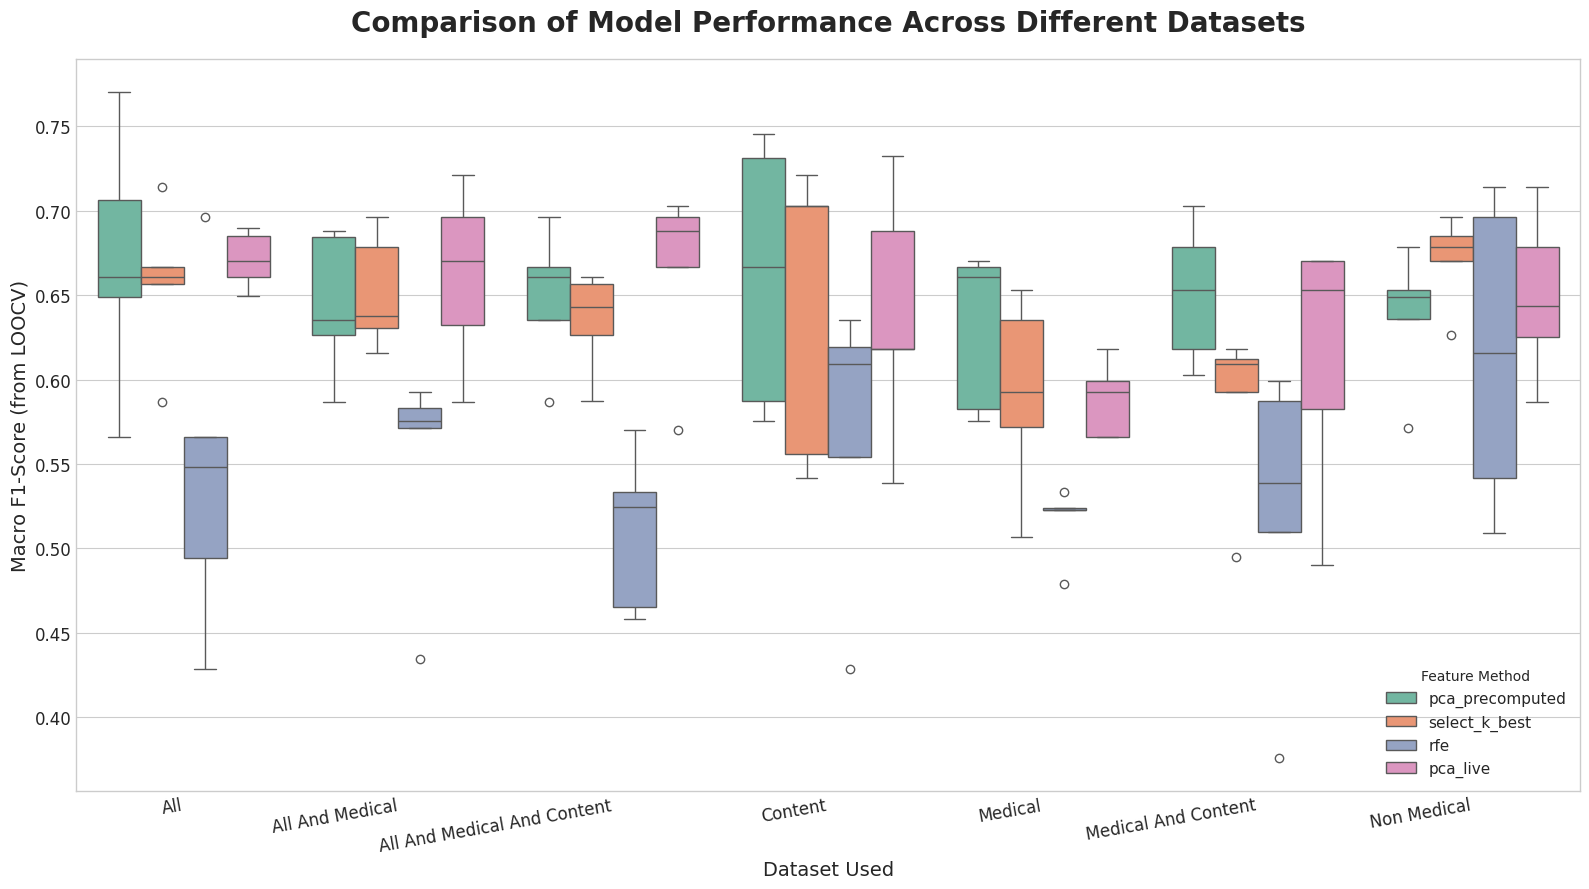

In [2]:
# --- Step 1: Find and Load All Bakeoff Summary Files ---

# Define the subfolder where your results are stored
results_folder = 'results'

# Update the pattern to include the subfolder path
file_pattern = os.path.join(results_folder, 'bakeoff_summary_*_summary_table.csv')
all_files = glob.glob(file_pattern)

if not all_files:
    print(f"Error: No files found matching the pattern '{file_pattern}'.")
    print("Please make sure your summary CSV files are in the same directory as the script.")
    exit()

print(f"Found {len(all_files)} files to compare: {all_files}")

# Create a list to hold the DataFrames
list_of_dfs = []

# Loop through each file found
for file_path in all_files:
    # Load the data
    df = pd.read_csv(file_path)

    # --- Extract a meaningful name from the filename ---
    # This regex looks for text between 'ml_features_' and a timestamp (like '2025...')
    match = re.search(r'ml_features_(.*?)_\d{8}', file_path)
    if match:
        data_source_name = match.group(1).replace('_', ' ').title()
    else:
        data_source_name = file_path # Fallback to the full filename if pattern fails

    # Add a new column to identify which file the data came from
    df['data_source'] = data_source_name
    list_of_dfs.append(df)

# Combine all the individual DataFrames into one master DataFrame
combined_df = pd.concat(list_of_dfs, ignore_index=True)


# --- Step 2: Create the Comparison Plot ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

# Create a box plot to compare the data sources.
# Using 'hue' for the 'method' will create grouped boxes for even more detail.
sns.boxplot(
    data=combined_df,
    x='data_source',
    y='loocv_f1_macro',
    hue='method', # This groups the results by feature engineering method
    palette='Set2'
)

# 3. Add titles and labels for clarity
plt.title('Comparison of Model Performance Across Different Datasets', fontsize=20, weight='bold', pad=20)
plt.xlabel('Dataset Used', fontsize=14)
plt.ylabel('Macro F1-Score (from LOOCV)', fontsize=14)
plt.xticks(rotation=10, ha='right', fontsize=12) # Rotate labels slightly if they are long
plt.yticks(fontsize=12)
plt.legend(title='Feature Method', fontsize=11)

# 4. Show the plot
plt.tight_layout()
plt.show()


## Model comparison across all datasets


Building a new, sanitized DataFrame to solve the plotting issue...


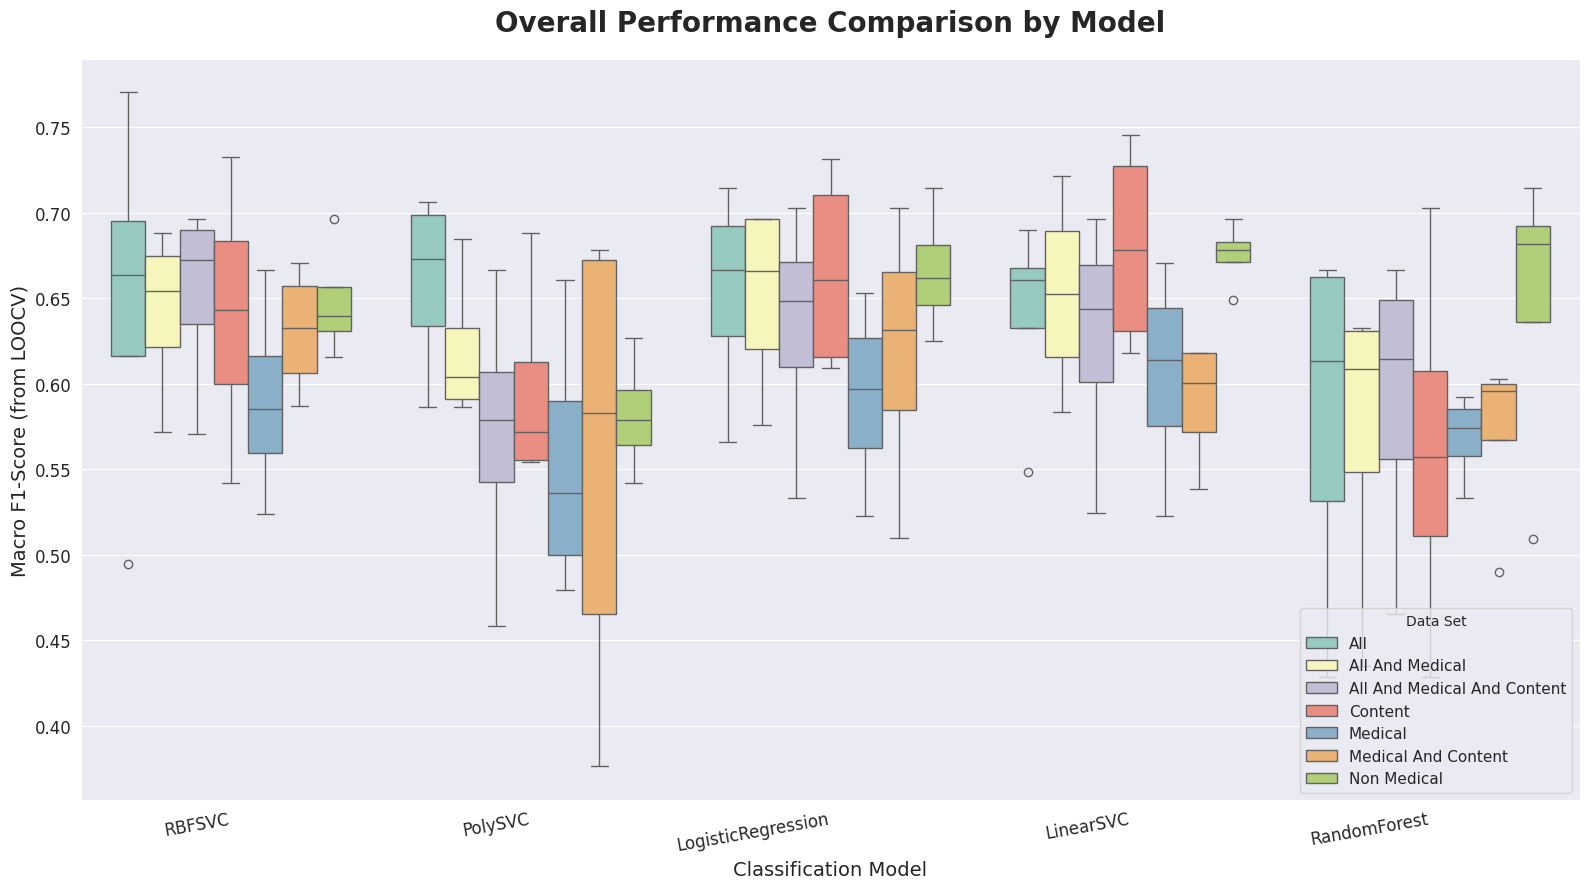

In [5]:
# --- Step 1: Find and Load All Bakeoff Summary Files ---

# Define the subfolder where your results are stored
results_folder = 'results'

# Update the pattern to include the subfolder path
file_pattern = os.path.join(results_folder, 'bakeoff_summary_*_summary_table.csv')
all_files = glob.glob(file_pattern)

if not all_files:
    print(f"Error: No files found matching the pattern '{file_pattern}'.")
    print("Please make sure your summary CSV files are in the same directory as the script.")
    exit()

# Create a list to hold the DataFrames
list_of_dfs = []

# Loop through each file found
for file_path in all_files:
    # Load the data
    df = pd.read_csv(file_path)

    # --- Extract a meaningful name from the filename ---
    # This regex looks for text between 'ml_features_' and a timestamp (like '2025...')
    match = re.search(r'ml_features_(.*?)_\d{8}', file_path)
    if match:
        data_source_name = match.group(1).replace('_', ' ').title()
    else:
        data_source_name = file_path # Fallback to the full filename if pattern fails

    # Add a new column to identify which file the data came from
    df['data_source'] = data_source_name
    list_of_dfs.append(df)

# Combine all the individual DataFrames into one master DataFrame
combined_df = pd.concat(list_of_dfs, ignore_index=True)

# --- Step 2: Filter for 'pca_live' Method Only for late use ---
unsanitized_filtered_df = combined_df[combined_df['method'] == 'pca_live'].copy()

# --- Step 3: Create a Sanitized DataFrame for Plotting ---
print("\nBuilding a new, sanitized DataFrame to solve the plotting issue...")
filtered_df = pd.DataFrame({
    'data_source': list(unsanitized_filtered_df['data_source']),
    'model_name': list(unsanitized_filtered_df['model_name']),
    'loocv_f1_macro': list(unsanitized_filtered_df['loocv_f1_macro'])
})

# --- Plot 1: Performance by Model ---
# This plot shows the overall performance of each model across all datasets.

# First, let's check if the 'model_name' column exists.
if 'model_name' not in combined_df.columns:
    print("Error: 'model_name' column not found in the DataFrame.")
    print("Please update the code with the correct column name for the model.")
else:
    plt.figure(figsize=(16, 9))
    sns.boxplot(
        data=combined_df,
        x='model_name',
        y='loocv_f1_macro',
        hue='data_source',
        palette='Set3'
    )

    plt.title('Overall Performance Comparison by Model', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Classification Model', fontsize=14)
    plt.ylabel('Macro F1-Score (from LOOCV)', fontsize=14)
    plt.xticks(rotation=10, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Data Set', fontsize=11, loc='lower right')
    plt.tight_layout()
    plt.show()

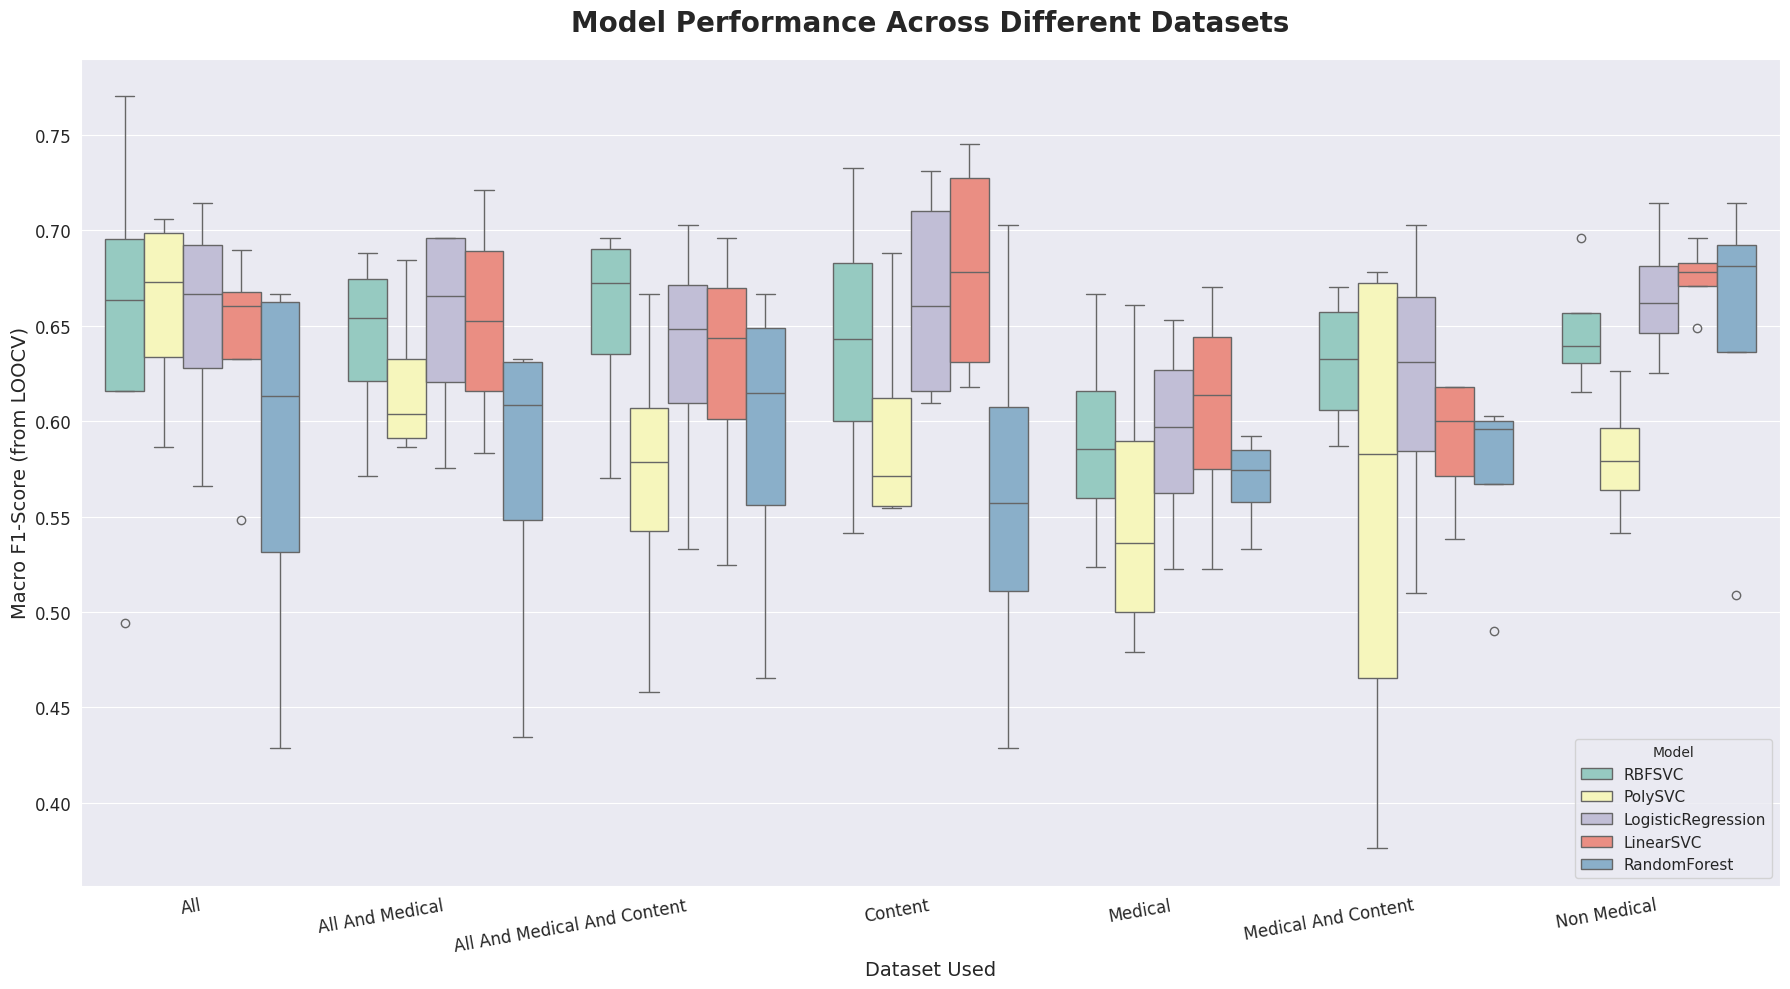

In [4]:
# --- Plot 2: Performance by Dataset, Grouped by Model ---
# This plot helps you see which models work best for specific datasets.

if 'model_name' not in combined_df.columns:
    print("Error: 'model_name' column not found. Skipping dataset-focused plot.")
else:
    plt.figure(figsize=(18, 10))
    sns.boxplot(
        data=combined_df,
        x='data_source',
        y='loocv_f1_macro',
        hue='model_name', # Group by model instead of feature method
        palette='Set3'
    )

    plt.title('Model Performance Across Different Datasets', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Dataset Used', fontsize=14)
    plt.ylabel('Macro F1-Score (from LOOCV)', fontsize=14)
    plt.xticks(rotation=10, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Model', fontsize=11, loc='lower right')
    plt.tight_layout()
    plt.show()

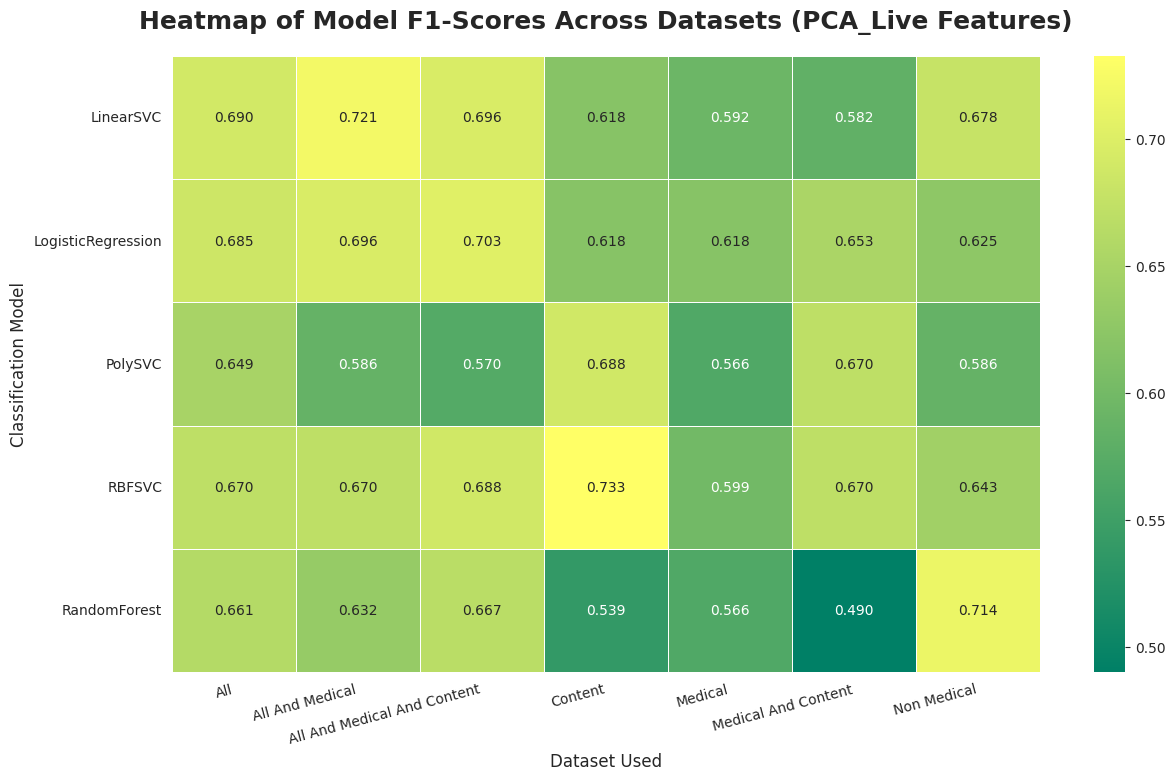

In [10]:
# --- Pivot the data for the heatmap ---
# We want models as rows, datasets as columns, and F1-score as the cell values.
try:
    pivot_df = filtered_df.pivot_table(
        index='model_name',
        columns='data_source',
        values='loocv_f1_macro'
    )

    # --- Create the Heatmap ---
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        pivot_df,
        annot=True,     # Show the F1-scores in the cells
        fmt=".3f",      # Format numbers to 3 decimal places
        cmap='summer', # A visually appealing color map
        linewidths=.5   # Add lines between cells
    )

    plt.title('Heatmap of Model F1-Scores Across Datasets (PCA_Live Features)', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Dataset Used', fontsize=12)
    plt.ylabel('Classification Model', fontsize=12)
    plt.xticks(rotation=15, ha='right')
    plt.yticks(rotation=0)
    plt.show()

except Exception as e:
    print(f"Could not create pivot table. Error: {e}")
    print("Please ensure you have unique rows for each model-dataset combination.")

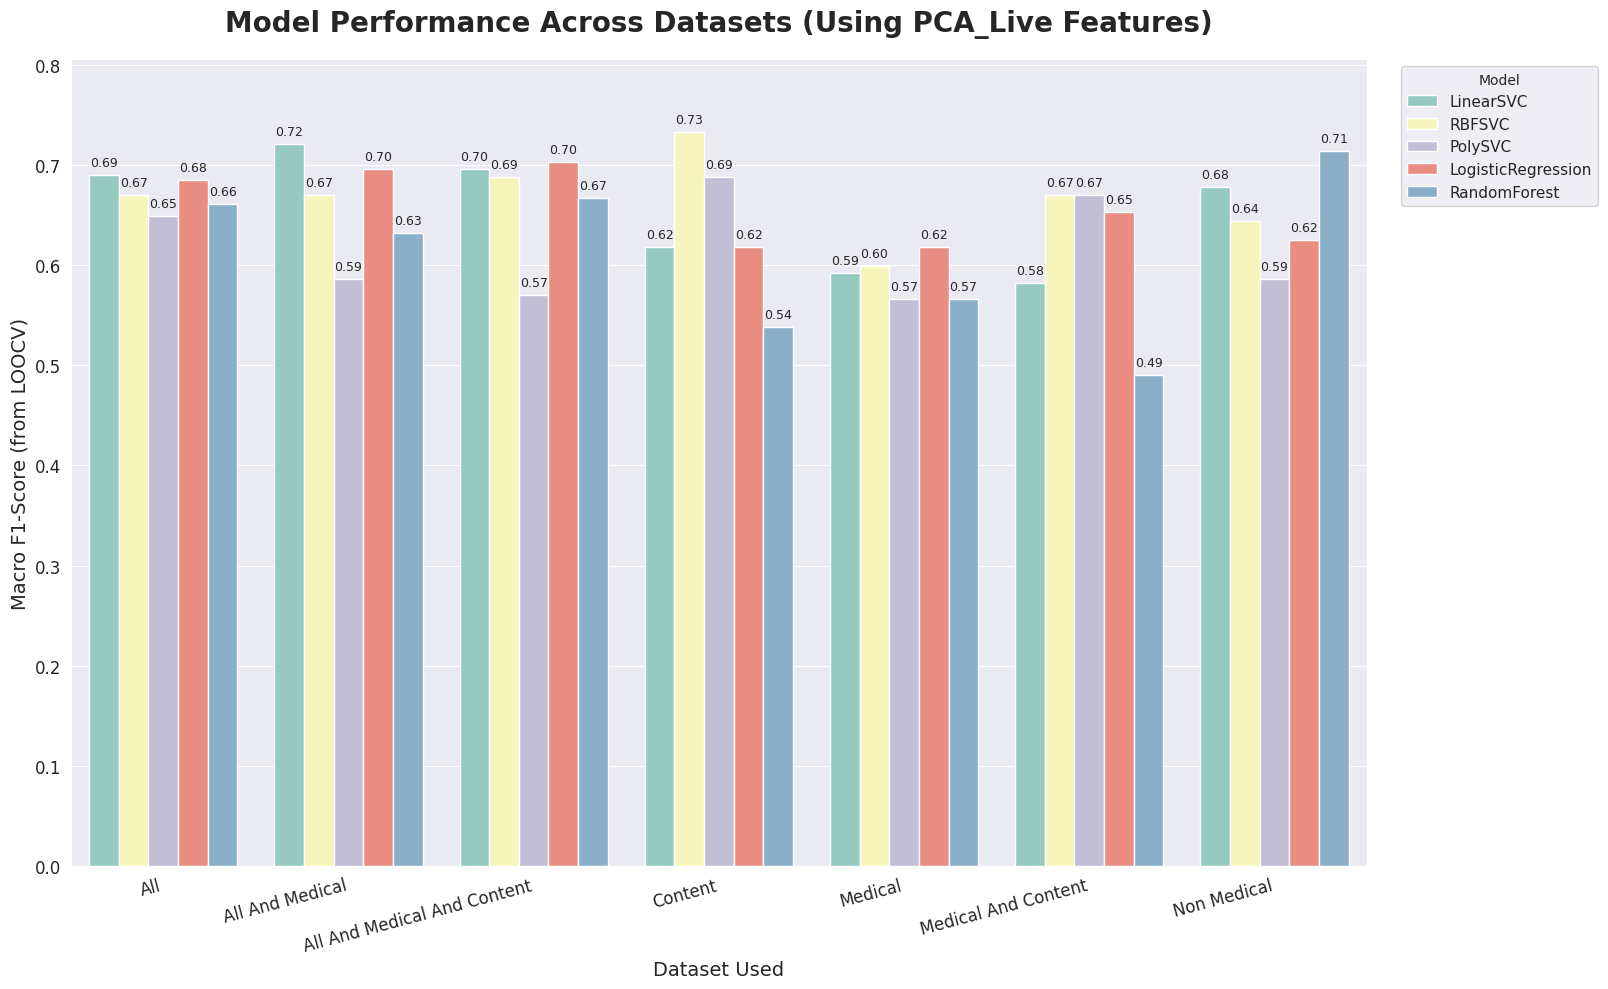

In [12]:
# --- Create the Grouped Bar Chart ---
plt.figure(figsize=(18, 10))
sns.barplot(
    data=filtered_df,
    x='data_source',
    y='loocv_f1_macro',
    hue='model_name', # Group bars by model
    palette='Set3'
)

# Add value labels on top of each bar
ax = plt.gca()
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9
        )

plt.title('Model Performance Across Datasets (Using PCA_Live Features)', fontsize=20, weight='bold', pad=20)
plt.xlabel('Dataset Used', fontsize=14)
plt.ylim(0, 1.1 * filtered_df['loocv_f1_macro'].max())
plt.ylabel('Macro F1-Score (from LOOCV)', fontsize=14)
plt.xticks(rotation=15, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', fontsize=11, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

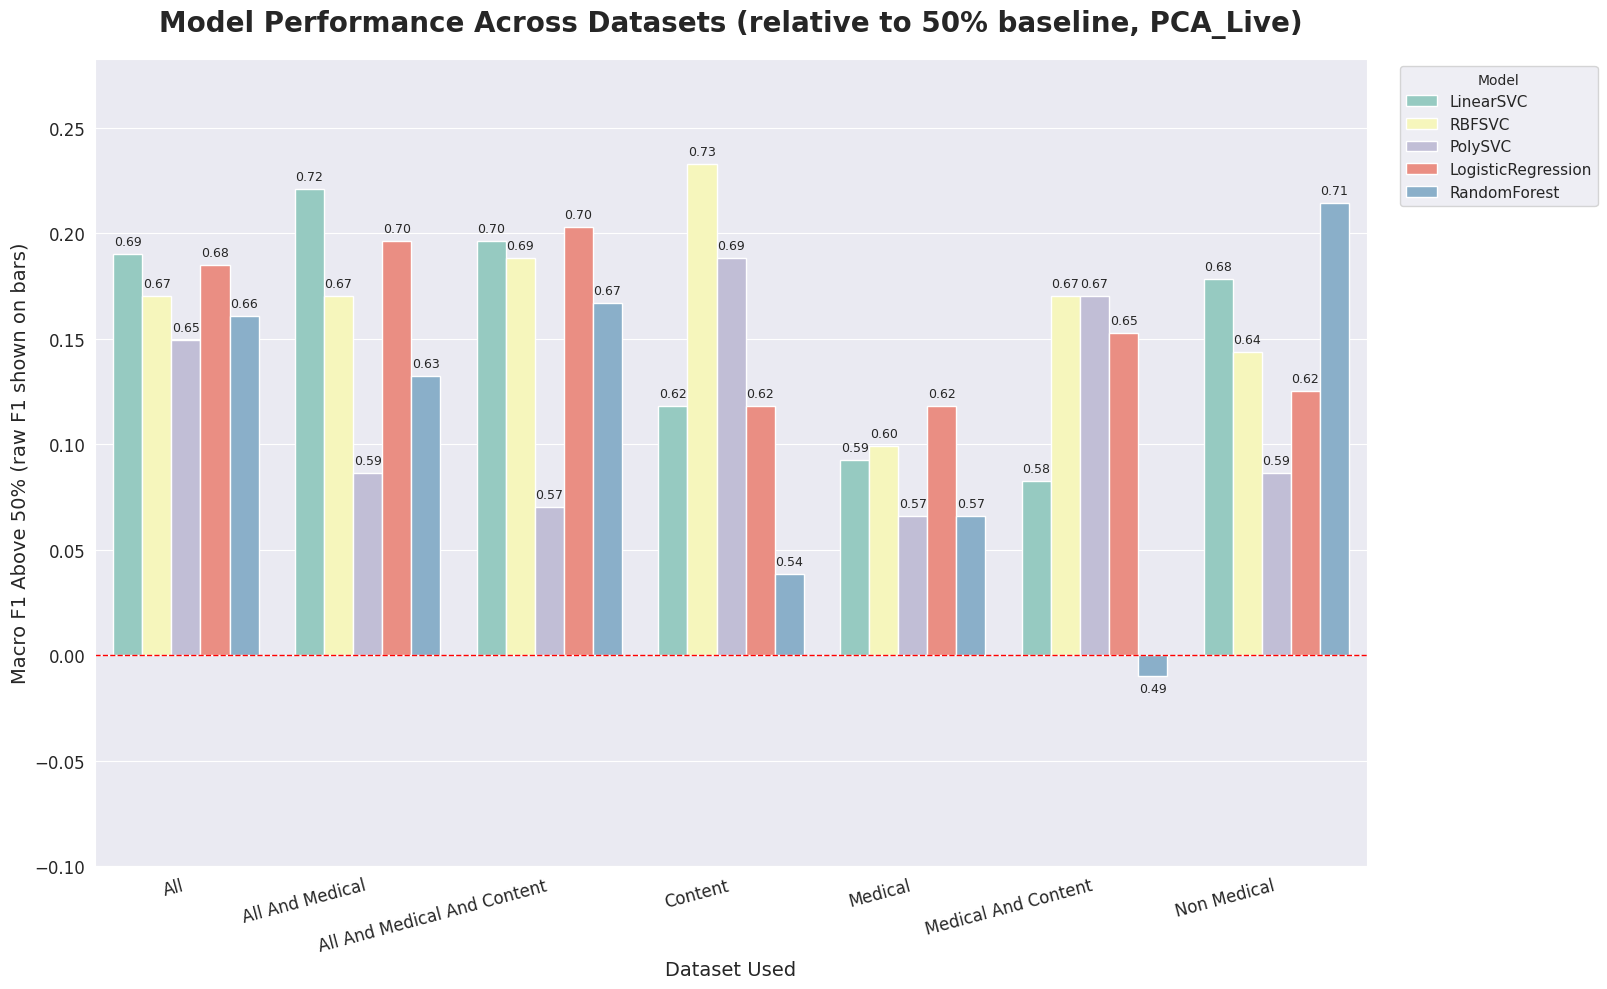

In [14]:
# --- Create the Grouped Bar Chart (relative to chance baseline) ---
df_plot = filtered_df.copy()
df_plot['f1_above_chance'] = df_plot['loocv_f1_macro'] - 0.5  # 0 = chance (data F1 = 0.5)

plt.figure(figsize=(18, 10))
ax = sns.barplot(
    data=df_plot,
    x='data_source',
    y='f1_above_chance',
    hue='model_name',
    palette='Set3'
)

# Baseline at 0 (i.e., data F1 = 0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=1)

# Y-limits
pad = 0.05
ymin = min(df_plot['f1_above_chance'].min(), -pad) - pad
ymax = max(df_plot['f1_above_chance'].max(),  pad) + pad
ax.set_ylim(ymin, ymax)

# Labels: show data F1 on bars, skip baseline bars (height ~ 0)
for p in ax.patches:
    h = p.get_height()
    if (h is None) or np.isnan(h) or np.isclose(h, 0.0, atol=1e-6):
        continue  # skip bars right on the chance baseline
    raw_f1 = h + 0.5
    x = p.get_x() + p.get_width() / 2.0
    offset = 9 if h >= 0 else -9
    ax.annotate(f"{raw_f1:.2f}", (x, h),
                ha='center', va='center',
                xytext=(0, offset), textcoords='offset points',
                fontsize=9)

ax.set_title('Model Performance Across Datasets (relative to 50% baseline, PCA_Live)', fontsize=20, weight='bold', pad=20)
ax.set_xlabel('Dataset Used', fontsize=14)
ax.set_ylabel('Macro F1 Above 50% (data F1 shown on bars)', fontsize=14)
plt.xticks(rotation=15, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', fontsize=11, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [2]:
# Multi-file bakeoff LaTeX exporter (no column normalization).
# - Scans a "results" directory for files matching your pattern
# - Extracts dataset names from filenames
# - Builds per-dataset LaTeX tables with: Accuracy, Precision (Macro), Recall (Macro), F1 (Macro)
# - Optionally includes Weighted F1 if present
# - Produces combined tables (all datasets) and "best per dataset" summaries
#
# Files will be written to /mnt/data/bakeoff_tables_v3

RESULTS_DIR = Path("results")
OUT_DIR = Path("results/latex")
OUT_DIR.mkdir(parents=True, exist_ok=True)

REQ = [
    "model_name",
    "method",
    "loocv_accuracy",
    "loocv_precision_macro",
    "loocv_recall_macro",
    "loocv_f1_macro",
]
OPT = ["loocv_f1_weighted"]

pattern = "bakeoff_summary_*_summary_table.csv"
files = sorted(RESULTS_DIR.glob(pattern))
single_csv = Path("results/macro/bakeoff_summary_ml_features_all_20250709_214248_summary_table.csv")
if single_csv.exists():
    files.append(single_csv)

def infer_dataset(fname: str) -> str:
    m = re.search(r"ml_features_(.*?)_\d{8}", fname)
    if m:
        return m.group(1).replace("_", " ").title()
    return Path(fname).stem

def esc(s: str) -> str:
    if not isinstance(s, str):
        return s
    return (s
            .replace("&", r"\&")
            .replace("%", r"\%")
            .replace("$", r"\$")
            .replace("#", r"\#")
            .replace("_", r"\_")
            .replace("{", r"\{")
            .replace("}", r"\}")
            .replace("~", r"\textasciitilde{}")
            .replace("^", r"\textasciicircum{}"))

def latex_from_df(df: pd.DataFrame, caption: str, label: str, include_weighted: bool) -> str:
    cols = ["model_name", "method", "loocv_accuracy", "loocv_precision_macro", "loocv_recall_macro", "loocv_f1_macro"]
    headers = ["Model", "Method", "Accuracy", "Precision (Macro)", "Recall (Macro)", "F1 (Macro)"]
    if include_weighted and "loocv_f1_weighted" in df.columns:
        cols.append("loocv_f1_weighted")
        headers.append("F1 (Weighted)")

    df = df.sort_values(["loocv_f1_macro", "loocv_accuracy"], ascending=[False, False]).copy()
    for c in ["loocv_accuracy", "loocv_precision_macro", "loocv_recall_macro", "loocv_f1_macro", "loocv_f1_weighted"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").map(lambda x: f"{x:.2f}" if pd.notnull(x) else "")
    for c in ["model_name","method"]:
        if c in df.columns:
            df[c] = df[c].astype(str).map(esc)

    header_line = " & ".join(headers) + r" \\"
    colspec = "ll" + "r"*(len(cols)-2)
    rows = "\n".join([" & ".join(map(str, row)) + r" \\" for row in df[cols].to_numpy()])

    tex = dedent(f"""
    \\begin{{table}}[t]
    \\centering
    \\resizebox{{\\textwidth}}{{!}}{{%
    \\begin{{tabular}}{{{colspec}}}
    \\toprule
    {header_line}
    \\midrule
    {rows}
    \\bottomrule
    \\end{{tabular}}%
    }}
    \\caption{{{caption}}}
    \\label{{{label}}}
    \\end{{table}}
    """).strip()
    return tex

per_dataset_tex_paths = []
accum_rows = []

for f in files:
    try:
        df = pd.read_csv(f)
    except Exception as e:
        # skip unreadable files
        continue
    missing = [c for c in REQ if c not in df.columns]
    if missing:
        # skip files that don't match expected schema
        continue
    dataset = infer_dataset(f.name)
    # Keep only needed columns
    keep = [c for c in (REQ + OPT) if c in df.columns]
    slim = df[keep].copy()
    # Write per-dataset full table
    tex = latex_from_df(
        slim,
        caption=f"Model comparison for {dataset} (LOOCV across methods).",
        label=f"tab:{re.sub('[^a-zA-Z0-9]+','_',dataset.lower())}_bakeoff",
        include_weighted=True
    )
    outp = OUT_DIR / f"{re.sub('[^a-zA-Z0-9]+','_',dataset.lower())}_bakeoff.tex"
    outp.write_text(tex, encoding="utf-8")
    per_dataset_tex_paths.append(str(outp))
    # Aggregate for combined
    slim.insert(0, "dataset", dataset)
    accum_rows.append(slim)

# Build combined tables
if accum_rows:
    combined = pd.concat(accum_rows, ignore_index=True)
    cols = ["dataset"] + REQ + [c for c in OPT if c in combined.columns]
    comb_sorted = combined.sort_values(["dataset","loocv_f1_macro","loocv_accuracy"], ascending=[True, False, False]).copy()
    for c in ["loocv_accuracy","loocv_precision_macro","loocv_recall_macro","loocv_f1_macro","loocv_f1_weighted"]:
        if c in comb_sorted.columns:
            comb_sorted[c] = pd.to_numeric(comb_sorted[c], errors="coerce").map(lambda x: f"{x:.2f}" if pd.notnull(x) else "")
    for c in ["dataset","model_name","method"]:
        if c in comb_sorted.columns:
            comb_sorted[c] = comb_sorted[c].astype(str).map(esc)
    headers = ["Dataset", "Model", "Method", "Accuracy", "Precision (Macro)", "Recall (Macro)", "F1 (Macro)"]
    if "loocv_f1_weighted" in comb_sorted.columns:
        headers.append("F1 (Weighted)")
    header_line = " & ".join(headers) + r" \\"
    colspec = "lll" + "r"*(len(headers)-3)
    rows = "\n".join([" & ".join(map(str, row)) + r" \\" for row in comb_sorted[["dataset","model_name","method","loocv_accuracy","loocv_precision_macro","loocv_recall_macro","loocv_f1_macro"] + (["loocv_f1_weighted"] if "loocv_f1_weighted" in comb_sorted.columns else [])].to_numpy()])
    combined_tex = dedent(f"""
    \\begin{{table}}[t]
    \\centering
    \\begin{{tabular}}{{{colspec}}}
    \\toprule
    {header_line}
    \\midrule
    {rows}
    \\bottomrule
    \\end{{tabular}}
    \\caption{{Combined model comparison across datasets (LOOCV).}}
    \\label{{tab:bakeoff_combined}}
    \\end{{table}}
    """).strip()
    (OUT_DIR / "bakeoff_combined.tex").write_text(combined_tex, encoding="utf-8")

    # Best per dataset (by macro F1 then accuracy)
    best_per_dataset = (combined
                        .sort_values(["dataset","loocv_f1_macro","loocv_accuracy"], ascending=[True, False, False])
                        .groupby("dataset", as_index=False)
                        .first())
    # Reorder/round for display
    disp_cols = ["dataset","model_name","method","loocv_accuracy","loocv_precision_macro","loocv_recall_macro","loocv_f1_macro"]
    if "loocv_f1_weighted" in best_per_dataset.columns:
        disp_cols.append("loocv_f1_weighted")
    best_display = best_per_dataset[disp_cols].copy()
    for c in ["loocv_accuracy","loocv_precision_macro","loocv_recall_macro","loocv_f1_macro","loocv_f1_weighted"]:
        if c in best_display.columns:
            best_display[c] = pd.to_numeric(best_display[c], errors="coerce").map(lambda x: round(x, 3) if pd.notnull(x) else None)

    # LaTeX for best per dataset
    for c in ["dataset","model_name","method"]:
        best_per_dataset[c] = best_per_dataset[c].astype(str).map(esc)
    for c in ["loocv_accuracy","loocv_precision_macro","loocv_recall_macro","loocv_f1_macro","loocv_f1_weighted"]:
        if c in best_per_dataset.columns:
            best_per_dataset[c] = pd.to_numeric(best_per_dataset[c], errors="coerce").map(lambda x: f"{x:.2f}" if pd.notnull(x) else "")
    headers = ["Dataset","Model","Method","Accuracy","Precision (Macro)","Recall (Macro)","F1 (Macro)"]
    if "loocv_f1_weighted" in best_per_dataset.columns:
        headers.append("F1 (Weighted)")
    header_line = " & ".join(headers) + r" \\"
    colspec = "lll" + "r"*(len(headers)-3)
    rows = "\n".join([" & ".join(map(str, row)) + r" \\" for row in best_per_dataset[["dataset","model_name","method","loocv_accuracy","loocv_precision_macro","loocv_recall_macro","loocv_f1_macro"] + (["loocv_f1_weighted"] if "loocv_f1_weighted" in best_per_dataset.columns else [])].to_numpy()])
    best_tex = dedent(f"""
    \\begin{{table}}[t]
    \\centering
    \\begin{{tabular}}{{{colspec}}}
    \\toprule
    {header_line}
    \\midrule
    {rows}
    \\bottomrule
    \\end{{tabular}}
    \\caption{{Best model per dataset (ranked by Macro F1; accuracy tie-breaker).}}
    \\label{{tab:best_per_dataset}}
    \\end{{table}}
    """).strip()
    (OUT_DIR / "best_per_dataset.tex").write_text(best_tex, encoding="utf-8")

# Write an index with paths
index_txt = "\n".join([
    "Generated files in /mnt/data/bakeoff_tables_v3:",
    *[Path(p).name for p in per_dataset_tex_paths],
    "bakeoff_combined.tex" if (OUT_DIR / "bakeoff_combined.tex").exists() else "",
    "best_per_dataset.tex" if (OUT_DIR / "best_per_dataset.tex").exists() else "",
])
(OUT_DIR / "INDEX.txt").write_text(index_txt, encoding="utf-8")

sorted([str(p) for p in OUT_DIR.iterdir()])


['results/macro/latex/INDEX.txt',
 'results/macro/latex/all_and_medical_and_content_bakeoff.tex',
 'results/macro/latex/all_and_medical_bakeoff.tex',
 'results/macro/latex/all_bakeoff.tex',
 'results/macro/latex/bakeoff_combined.tex',
 'results/macro/latex/best_per_dataset.tex',
 'results/macro/latex/content_bakeoff.tex',
 'results/macro/latex/medical_and_content_bakeoff.tex',
 'results/macro/latex/medical_bakeoff.tex',
 'results/macro/latex/non_medical_bakeoff.tex']

In [18]:
# ---------------------- CONFIG ---------------------- #
RESULTS_DIR = Path("results")            # root folder holding the bakeoff CSVs (searched recursively)
OUT_DIR = Path("results/averages")       # where to save CSVs and plots

# Choose methods: "ALL" or a list like ["pca_live", "select_k_best", "rfe"]
METHODS = ["pca_live", "select_k_best", "rfe"]

# Choose models: "ALL" or a list like ["LinearSVC", "RBFSVC", "PolySVC", "LogisticRegression", "RandomForest"]
MODELS = "ALL"

# Choose metrics: "ALL" or a list of aliases / exact column names, e.g. ["macro_f1", "weighted_f1", "accuracy"]
# Aliases supported out of the box: weighted_f1, macro_f1, accuracy, macro_precision, macro_recall
METRICS = [
    "loocv_accuracy",
    "loocv_precision_macro",
    "loocv_recall_macro",
    "loocv_f1_macro"
]

# Plot controls
PLOT_BARS = True          # per-metric bar chart (mean ± sd by dataset)
PLOT_HEATMAP = True       # per-metric dataset × model heatmap of mean
TITLE_SUFFIX = ""         # appended to plot titles (e.g., "PCA-live only")

# ---------------------------------------------------- #
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Config loaded.")
print("RESULTS_DIR:", RESULTS_DIR.resolve())
print("OUT_DIR:", OUT_DIR.resolve())
print("METHODS:", METHODS)
print("MODELS:", MODELS)
print("METRICS:", METRICS)
print("PLOT_BARS:", PLOT_BARS, "| PLOT_HEATMAP:", PLOT_HEATMAP)
print("TITLE_SUFFIX:", TITLE_SUFFIX)


Config loaded.
RESULTS_DIR: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results
OUT_DIR: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/averages
METHODS: ['pca_live', 'select_k_best', 'rfe']
MODELS: ALL
METRICS: ['loocv_accuracy', 'loocv_precision_macro', 'loocv_recall_macro', 'loocv_f1_macro']
PLOT_BARS: True | PLOT_HEATMAP: True
TITLE_SUFFIX: 


In [19]:
# Load → Discover → Filter
# - Recursively loads all `bakeoff_summary_*_summary_table.csv` from `RESULTS_DIR`
# - Discovers available **methods**, **models**, and **metric columns**
# - Applies `METHODS`, `MODELS`, and `METRICS` filters (with `"ALL"` support)
#
# If no files are found, this cell will inform you what to do.


# --- Metric alias map (extendable) ---
METRIC_ALIASES = {
    "weighted_f1": ["loocv_f1_weighted", "weighted_f1", "f1_weighted", "F1 (Weighted)"],
    "macro_f1": ["loocv_f1_macro", "macro_f1", "f1_macro", "F1 (Macro)"],
    "accuracy": ["loocv_accuracy", "accuracy", "Accuracy"],
    "macro_precision": ["loocv_precision_macro", "precision_macro", "Precision (Macro)"],
    "macro_recall": ["loocv_recall_macro", "recall_macro", "Recall (Macro)"],
}

def discover_metric_column(df: pd.DataFrame, requested: str) -> str:
    """Resolve requested alias or exact column name to a concrete column in df."""
    # exact
    if requested in df.columns:
        return requested
    key = requested.lower()
    # alias
    if key in METRIC_ALIASES:
        for col in METRIC_ALIASES[key]:
            if col in df.columns:
                return col
        raise ValueError(f"No column found for alias '{requested}'. Tried: {METRIC_ALIASES[key]}")
    # case-insensitive exact
    for col in df.columns:
        if col.lower() == requested.lower():
            return col
    raise ValueError(f"Unknown metric '{requested}'. Available columns include: {list(df.columns)}")

def find_bakeoff_files(root: Path) -> list[Path]:
    pattern = str(root / "**" / "bakeoff_summary_*_summary_table.csv")
    return [Path(p) for p in glob.glob(pattern, recursive=True)]

# --- Load all CSVs ---
files = find_bakeoff_files(RESULTS_DIR)
print(f"Found {len(files)} files under {RESULTS_DIR} (recursive).")
if not files:
    # Display a hint and stop early
    empty = pd.DataFrame()
else:
    frames = []
    for fp in files:
        try:
            df = pd.read_csv(fp)
            # dataset name from filename
            m = re.search(r"ml_features_(.*?)_\d{8}", fp.name)
            ds = m.group(1).replace("_", " ").title() if m else fp.stem
            df["data_source"] = ds
            frames.append(df)
            print("Loaded:", fp.name, "->", ds)
        except Exception as e:
            print("Warning: could not load", fp, ":", e)


    combined = pd.concat(frames, ignore_index=True)
    # Discover available methods/models/metrics
    available_methods = sorted(combined["method"].dropna().unique()) if "method" in combined.columns else []
    available_models = sorted(combined["model_name"].dropna().unique()) if "model_name" in combined.columns else []
    print("\nDiscovered methods:", available_methods)
    print("Discovered models:", available_models)

    # Build metric discovery: union of all alias target columns that exist
    discovered_metric_cols = []
    for alias, cols in METRIC_ALIASES.items():
        for c in cols:
            if c in combined.columns:
                discovered_metric_cols.append(c)
    # Add any column that looks like a metric (heuristic)
    heuristic_metrics = [c for c in combined.columns if re.search(r"(f1|accuracy|precision|recall)", c, re.I)]
    discovered_metric_cols = sorted(set(discovered_metric_cols + heuristic_metrics))
    print("Discovered metric columns:", discovered_metric_cols[:10], "..." if len(discovered_metric_cols) > 10 else "")

    # Resolve METHODS
    if METHODS == "ALL":
        sel_methods = available_methods
    else:
        sel_methods = [m for m in METHODS if m in available_methods]
        missing = set(METHODS) - set(sel_methods)
        if missing:
            print("Note: these METHODS not found and will be ignored:", sorted(missing))

    # Resolve MODELS
    if MODELS == "ALL":
        sel_models = available_models
    else:
        sel_models = [m for m in MODELS if m in available_models]
        missing = set(MODELS) - set(sel_models)
        if missing:
            print("Note: these MODELS not found and will be ignored:", sorted(missing))

    # Resolve METRICS (list or "ALL")
    if METRICS == "ALL":
        # Use aliases that resolve to existing columns (stable names)
        sel_metric_aliases = []
        for alias in METRIC_ALIASES.keys():
            try:
                _ = discover_metric_column(combined, alias)
                sel_metric_aliases.append(alias)
            except Exception:
                pass
        if not sel_metric_aliases:
            raise ValueError("Could not resolve any metric aliases from data.")
    else:
        # keep them as provided (aliases or exacts)
        sel_metric_aliases = METRICS

    # Persist selections for later cells
    _SELECTIONS = {
        "methods": sel_methods,
        "models": sel_models,
        "metric_aliases": sel_metric_aliases,
        "discovered_metric_cols": discovered_metric_cols
    }

    print("\nSelections resolved:")
    print(" methods:", _SELECTIONS["methods"])
    print(" models:", _SELECTIONS["models"])
    print(" metrics (aliases/exacts):", _SELECTIONS["metric_aliases"])


Found 15 files under results (recursive).
Loaded: bakeoff_summary_ml_features_all_20250709_214248_summary_table.csv -> All
Loaded: bakeoff_summary_ml_features_all_and_medical_20250709_213116_summary_table.csv -> All And Medical
Loaded: bakeoff_summary_ml_features_all_and_medical_and_content_20250709_214000_summary_table.csv -> All And Medical And Content
Loaded: bakeoff_summary_ml_features_content_20250709_214417_summary_table.csv -> Content
Loaded: bakeoff_summary_ml_features_medical_20250709_214316_summary_table.csv -> Medical
Loaded: bakeoff_summary_ml_features_medical_and_content_20250709_214355_summary_table.csv -> Medical And Content
Loaded: bakeoff_summary_ml_features_non_medical_20250711_021809_summary_table.csv -> Non Medical
Loaded: bakeoff_summary_ml_features_all_20250709_214248_summary_table.csv -> All
Loaded: bakeoff_summary_ml_features_all_and_medical_20250709_213116_summary_table.csv -> All And Medical
Loaded: bakeoff_summary_ml_features_all_and_medical_and_content_20250


=== Metric: loocv_accuracy -> column: loocv_accuracy ===
Saved: results/averages/aggregated_per_dataset__loocv_accuracy.csv
Saved: results/averages/pivot_per_dataset__loocv_accuracy.csv


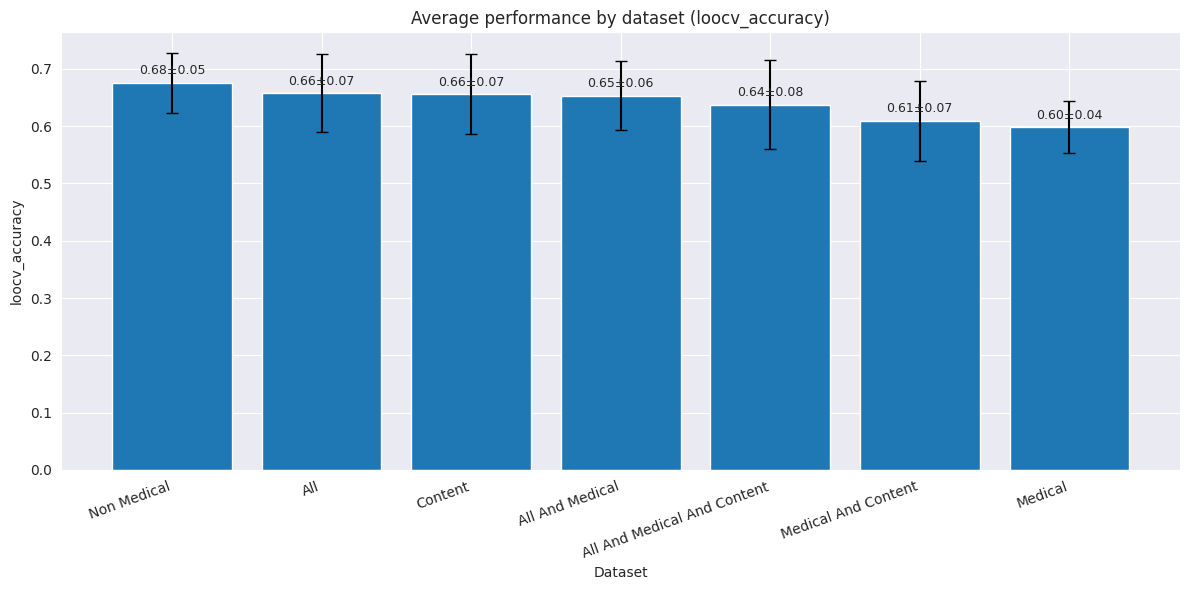

Saved plot: results/averages/bar__loocv_accuracy.png


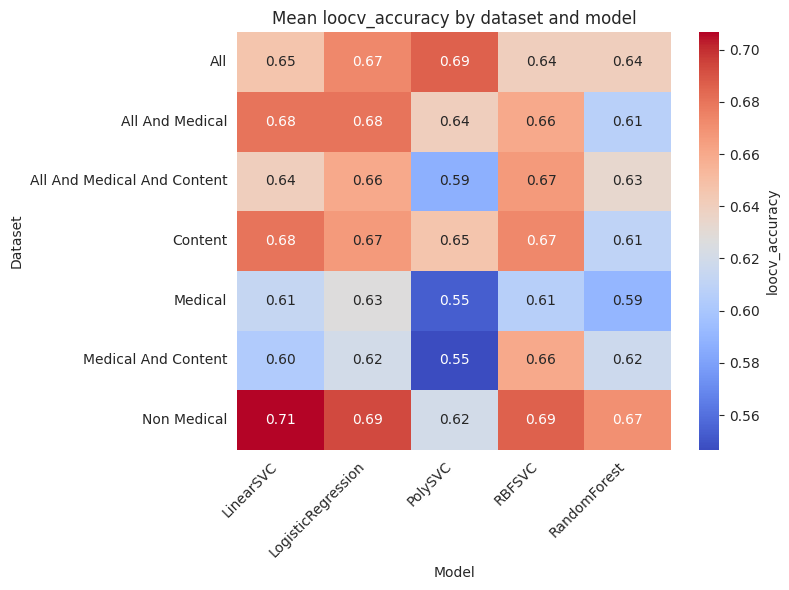

Saved plot: results/averages/heatmap__loocv_accuracy.png

=== Metric: loocv_precision_macro -> column: loocv_precision_macro ===
Saved: results/averages/aggregated_per_dataset__loocv_precision_macro.csv
Saved: results/averages/pivot_per_dataset__loocv_precision_macro.csv


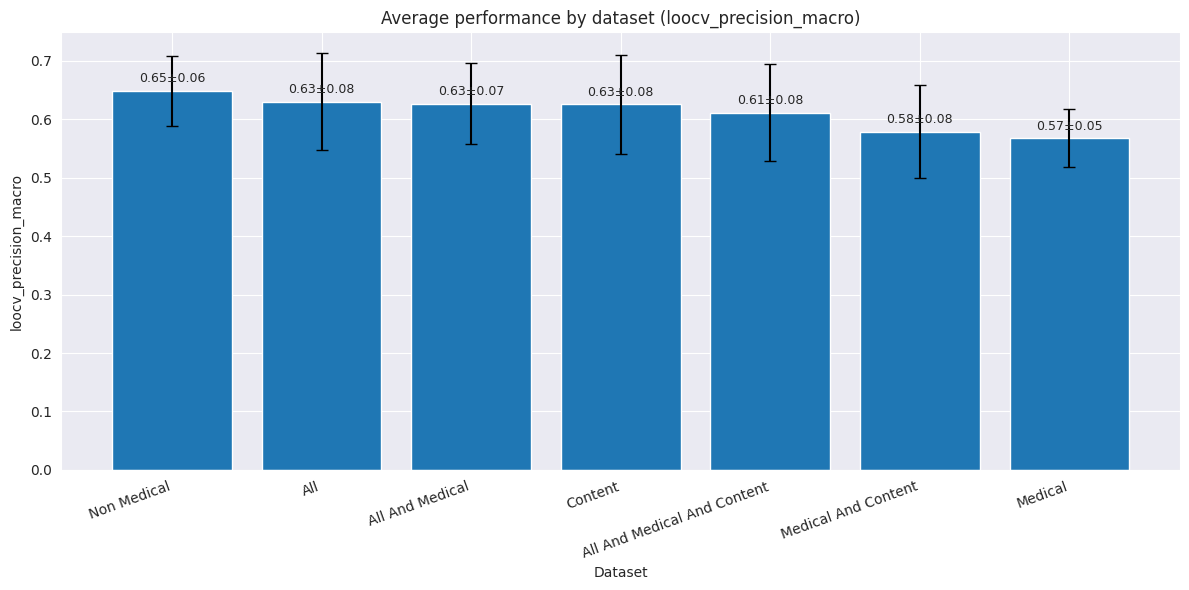

Saved plot: results/averages/bar__loocv_precision_macro.png


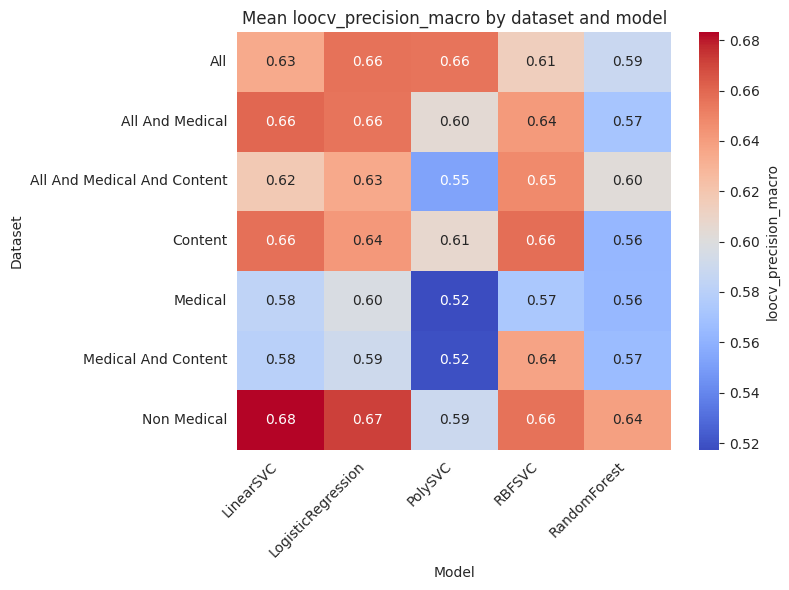

Saved plot: results/averages/heatmap__loocv_precision_macro.png

=== Metric: loocv_recall_macro -> column: loocv_recall_macro ===
Saved: results/averages/aggregated_per_dataset__loocv_recall_macro.csv
Saved: results/averages/pivot_per_dataset__loocv_recall_macro.csv


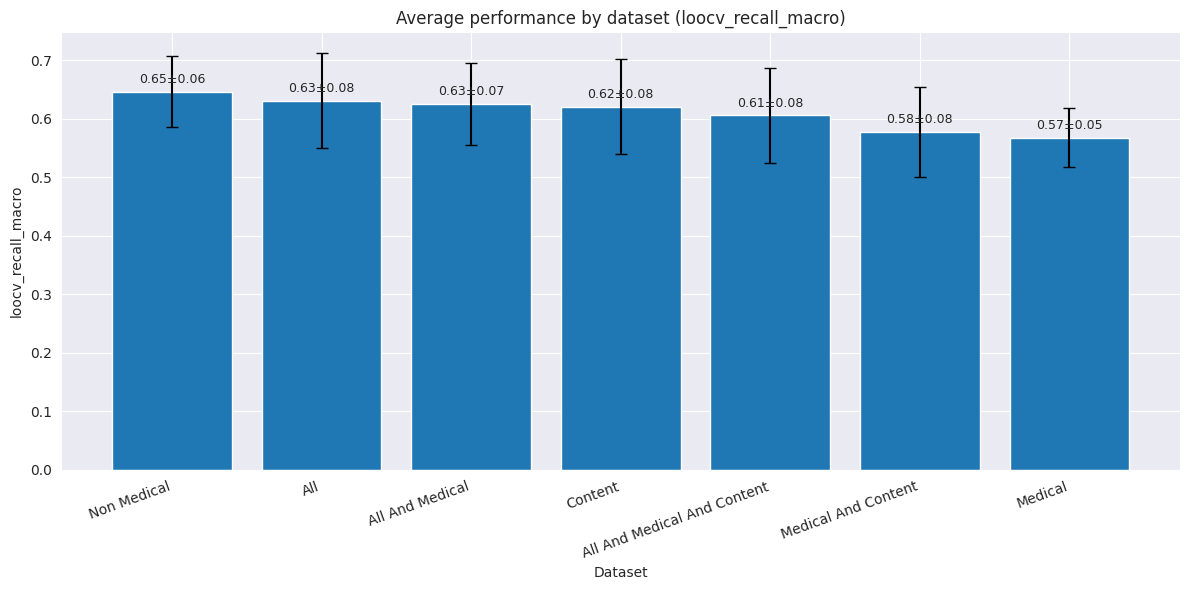

Saved plot: results/averages/bar__loocv_recall_macro.png


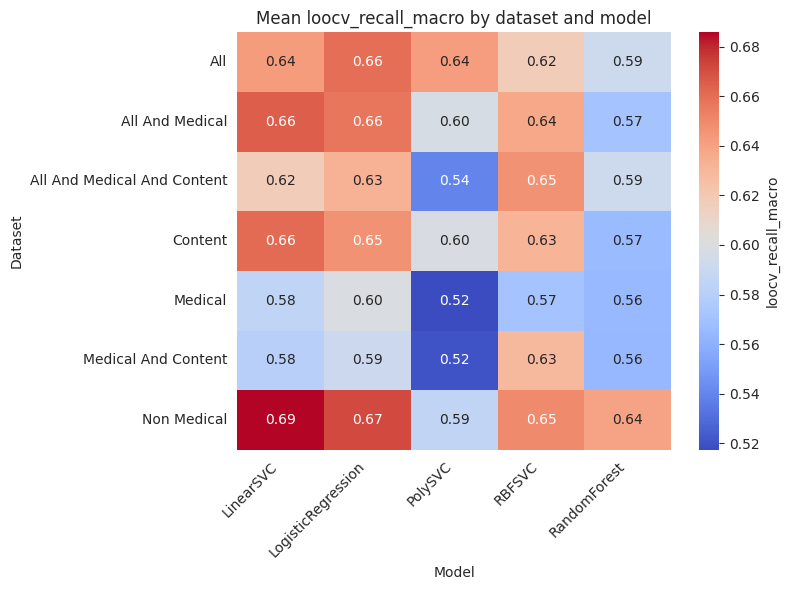

Saved plot: results/averages/heatmap__loocv_recall_macro.png

=== Metric: loocv_f1_macro -> column: loocv_f1_macro ===
Saved: results/averages/aggregated_per_dataset__loocv_f1_macro.csv
Saved: results/averages/pivot_per_dataset__loocv_f1_macro.csv


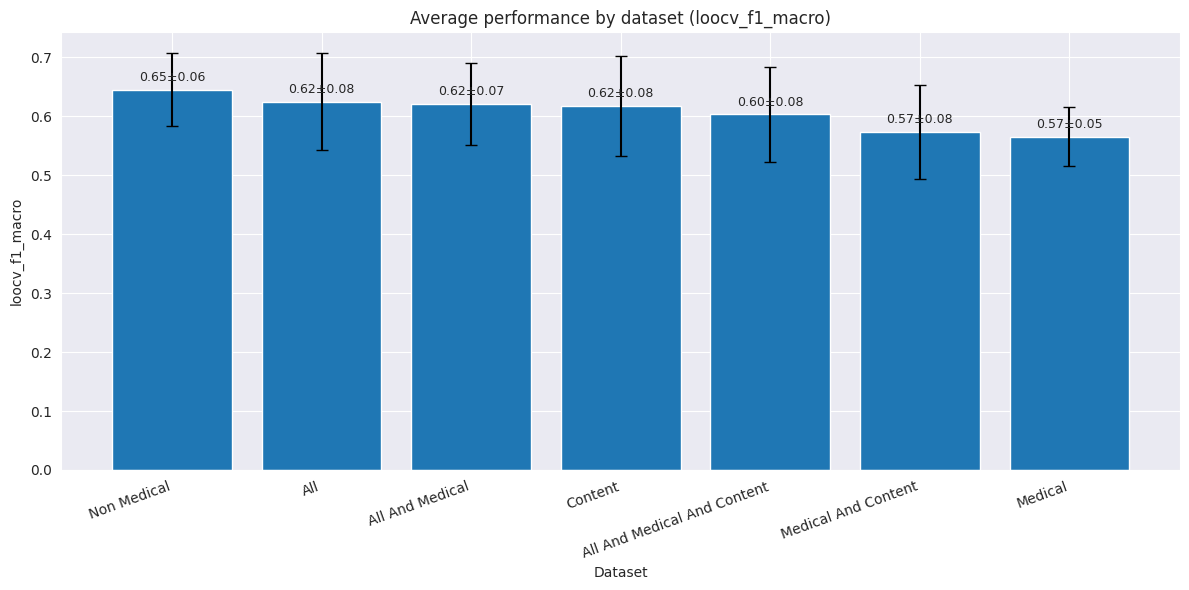

Saved plot: results/averages/bar__loocv_f1_macro.png


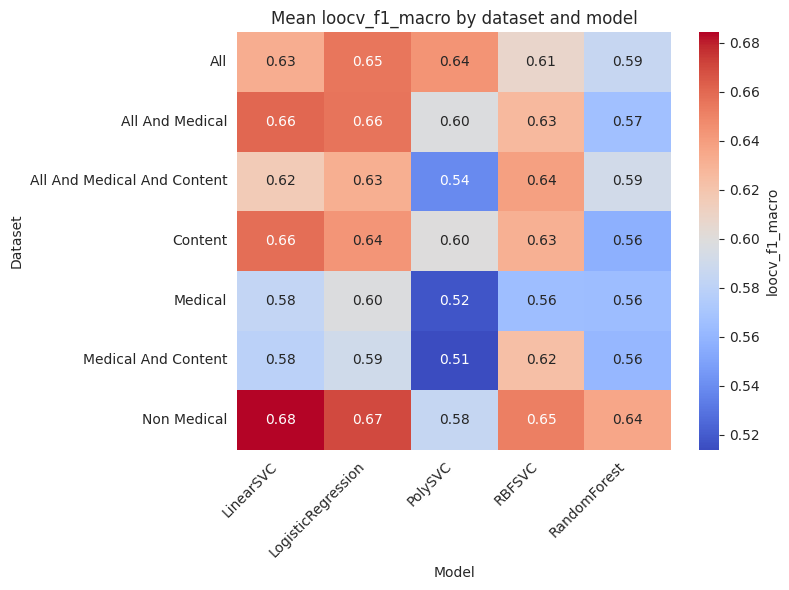

Saved plot: results/averages/heatmap__loocv_f1_macro.png

Done.


In [20]:
# Aggregate & Export (per metric)
# For each selected metric, we:
# - resolve the metric column,
# - filter by selected methods/models,
# - compute **mean, sd, count** per dataset,
# - build a **dataset × model** pivot of mean metric,
# - save to CSV,
# - and (optionally) plot.
#
# Tables are displayed in the notebook and also saved to `OUT_DIR`.

def run_per_metric_aggregation(combined: pd.DataFrame, metric_token: str):
    """Aggregate and export for a single metric alias or column name."""
    # Resolve metric column
    metric_col = discover_metric_column(combined, metric_token)
    print(f"\n=== Metric: {metric_token} -> column: {metric_col} ===")

    # Filter by methods/models
    df = combined.copy()
    if "method" not in df.columns or "model_name" not in df.columns:
        raise KeyError("Expected 'method' and 'model_name' columns in data.")
    df = df[df["method"].isin(_SELECTIONS["methods"])]
    df = df[df["model_name"].isin(_SELECTIONS["models"])]

    if df.empty:
        print("No rows remain after filtering — skipping.")
        return

    # Build analysis frame
    plot_df = df.rename(columns={metric_col: "metric"})[["data_source", "model_name", "method", "metric"]].copy()

    # Aggregate per dataset
    agg_df = (
        plot_df.groupby("data_source")["metric"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .sort_values("mean", ascending=False)
    )
    # Save + display aggregated
    agg_path = OUT_DIR / f"aggregated_per_dataset__{metric_token}.csv"
    agg_df.to_csv(agg_path, index=False)
    print("Saved:", agg_path)

    # Dataset × model pivot
    pivot_df = (
        plot_df.pivot_table(index="data_source", columns="model_name", values="metric", aggfunc="mean")
        .sort_index(axis=0)
        .sort_index(axis=1)
    )
    pivot_path = OUT_DIR / f"pivot_per_dataset__{metric_token}.csv"
    pivot_df.to_csv(pivot_path)
    print("Saved:", pivot_path)

    # --------- Plots (matplotlib only) ---------
    if PLOT_BARS:
        # bar with error bars
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(agg_df))
        means = agg_df["mean"].to_numpy()
        stds = np.nan_to_num(agg_df["std"].to_numpy(), nan=0.0)
        ax.bar(x, means, yerr=stds, capsize=4)
        ax.set_xticks(x, agg_df["data_source"], rotation=20, ha="right")
        title = f"Average performance by dataset ({metric_token})"
        if TITLE_SUFFIX:
            title += f" – {TITLE_SUFFIX}"
        ax.set_title(title)
        ax.set_xlabel("Dataset")
        ax.set_ylabel(metric_token)
        for xi, m, s in zip(x, means, stds):
            ax.text(xi, m + (0.01 if np.isfinite(m) else 0.0), f"{m:.2f}±{s:.2f}", ha="center", va="bottom", fontsize=9)
        fig.tight_layout()
        bar_path = OUT_DIR / f"bar__{metric_token}.png"
        fig.savefig(bar_path, dpi=200)
        plt.show()
        print("Saved plot:", bar_path)


        if PLOT_HEATMAP and not pivot_df.empty:
            fig, ax = plt.subplots(
                figsize=(max(8, 0.8 * (pivot_df.shape[1] + 3)),
                         max(6, 0.6 * (pivot_df.shape[0] + 3)))
            )
            sns.heatmap(
                pivot_df,
                annot=True, fmt=".2f", cmap="coolwarm",
                cbar_kws={"label": metric_token},
                ax=ax
            )
            ax.set_title(
                f"Mean {metric_token} by dataset and model" +
                (f" – {TITLE_SUFFIX}" if TITLE_SUFFIX else "")
            )
            ax.set_xlabel("Model")
            ax.set_ylabel("Dataset")
            plt.xticks(rotation=45, ha="right")
            fig.tight_layout()
            heatmap_path = OUT_DIR / f"heatmap__{metric_token}.png"
            fig.savefig(heatmap_path, dpi=200)
            plt.show()
            print("Saved plot:", heatmap_path)

# Run for each selected metric
if 'combined' not in globals():
    print("No combined data available yet. Run the previous cell after placing CSVs under RESULTS_DIR.")
elif '_SELECTIONS' not in globals():
    print("Selections not resolved. Re-run the previous cell.")
else:
    for metric_token in _SELECTIONS["metric_aliases"]:
        run_per_metric_aggregation(combined, metric_token)

print("\nDone.")



=== Per-Method Analysis for metric: loocv_accuracy (column: loocv_accuracy) ===
Saved: results/averages/method_stats__loocv_accuracy.csv
Saved: results/averages/best_method_per_dataset__loocv_accuracy.csv
Saved: results/averages/overall_method_ranking__loocv_accuracy.csv


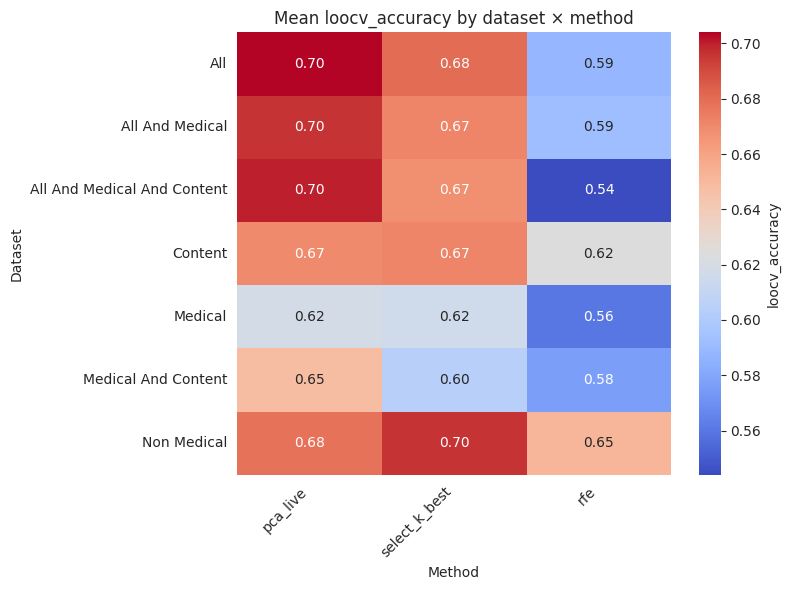

Saved plot: results/averages/heatmap_method__loocv_accuracy.png

=== Per-Method Analysis for metric: loocv_precision_macro (column: loocv_precision_macro) ===
Saved: results/averages/method_stats__loocv_precision_macro.csv
Saved: results/averages/best_method_per_dataset__loocv_precision_macro.csv
Saved: results/averages/overall_method_ranking__loocv_precision_macro.csv


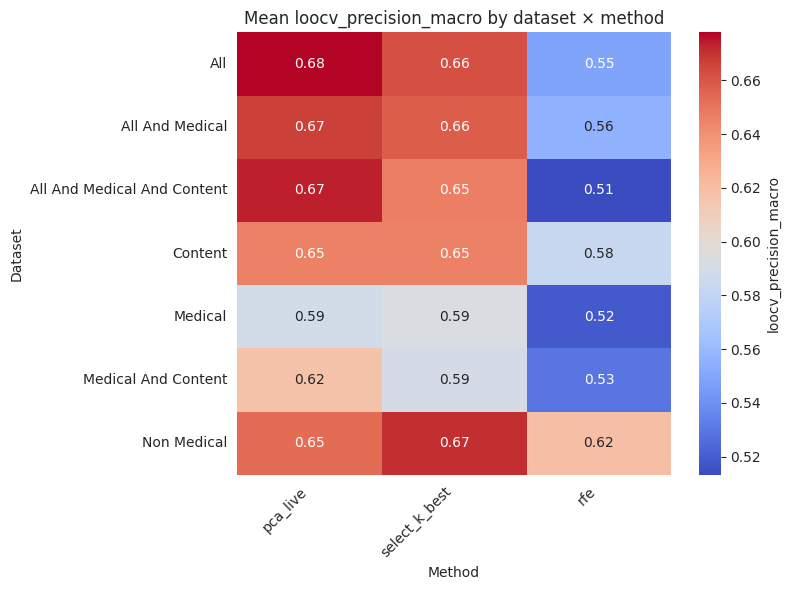

Saved plot: results/averages/heatmap_method__loocv_precision_macro.png

=== Per-Method Analysis for metric: loocv_recall_macro (column: loocv_recall_macro) ===
Saved: results/averages/method_stats__loocv_recall_macro.csv
Saved: results/averages/best_method_per_dataset__loocv_recall_macro.csv
Saved: results/averages/overall_method_ranking__loocv_recall_macro.csv


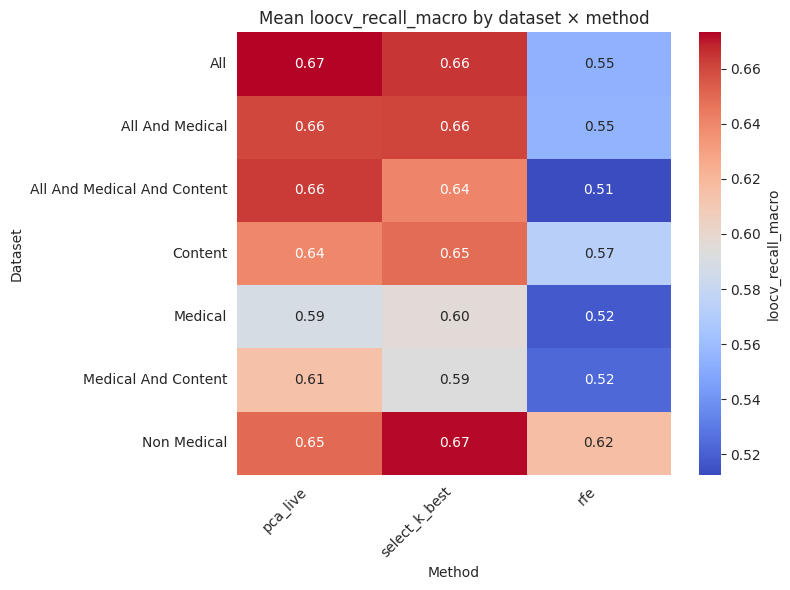

Saved plot: results/averages/heatmap_method__loocv_recall_macro.png

=== Per-Method Analysis for metric: loocv_f1_macro (column: loocv_f1_macro) ===
Saved: results/averages/method_stats__loocv_f1_macro.csv
Saved: results/averages/best_method_per_dataset__loocv_f1_macro.csv
Saved: results/averages/overall_method_ranking__loocv_f1_macro.csv


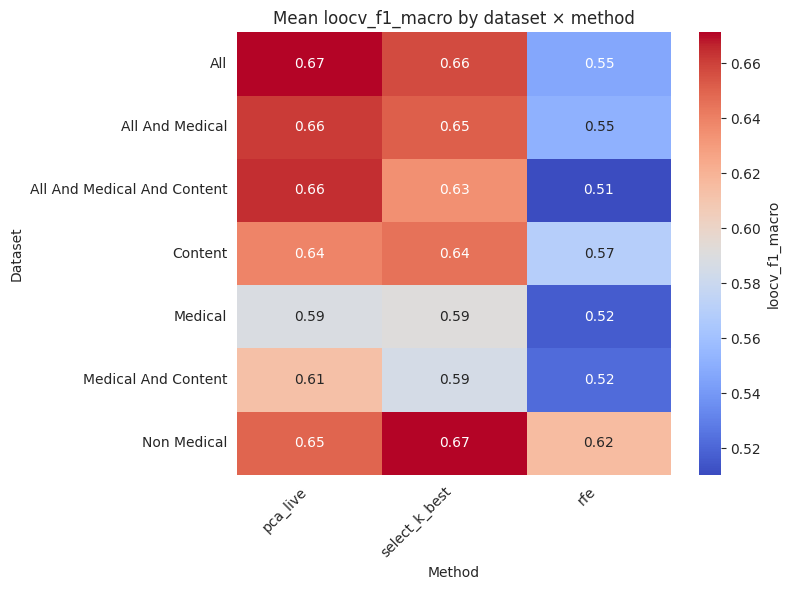

Saved plot: results/averages/heatmap_method__loocv_f1_macro.png

Per-method analysis done.


In [22]:
# Per-Method Analysis (Best Dimensionality Reduction per Dataset)
# For each selected **metric**, this cell will:
# - compute **mean, sd, count** per *(dataset × method)*
# - identify the **best method per dataset** (highest mean)
# - compute an **overall method ranking** (averaged across datasets)
# - export CSVs and show a **seaborn heatmap (coolwarm)** of *(dataset × method)* mean performance
#
# **Outputs** (per metric) saved under `OUT_DIR`:
# - `method_stats__<metric>.csv`
# - `best_method_per_dataset__<metric>.csv`
# - `overall_method_ranking__<metric>.csv`
# - `heatmap_method__<metric>.png`

def method_analysis_per_metric(combined: pd.DataFrame, metric_token: str):
    # Reuse resolver from earlier cell
    def discover_metric_column(df: pd.DataFrame, requested: str) -> str:
        if requested in df.columns:
            return requested
        key = requested.lower()
        if key in METRIC_ALIASES:
            for col in METRIC_ALIASES[key]:
                if col in df.columns:
                    return col
            raise ValueError(f"No column found for alias '{requested}'. Tried: {METRIC_ALIASES[key]}")
        for col in df.columns:
            if col.lower() == requested.lower():
                return col
        raise ValueError(f"Unknown metric '{requested}'. Available columns include: {list(df.columns)}")

    metric_col = discover_metric_column(combined, metric_token)
    print(f"\n=== Per-Method Analysis for metric: {metric_token} (column: {metric_col}) ===")

    # Filter by selected methods/models from previous selections
    df = combined.copy()
    if 'method' not in df.columns or 'model_name' not in df.columns:
        raise KeyError("Expected 'method' and 'model_name' columns in data.")
    df = df[df["method"].isin(_SELECTIONS["methods"])]
    df = df[df["model_name"].isin(_SELECTIONS["models"])]

    if df.empty:
        print("No rows remain after filtering — skipping.")
        return

    # Prepare analysis frame
    analysis_df = df.rename(columns={metric_col: "metric"})[["data_source", "method", "metric"]].copy()

    # 1) Stats per dataset × method
    method_stats = (
        analysis_df.groupby(["data_source", "method"])["metric"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .sort_values(["data_source", "mean"], ascending=[True, False])
    )
    method_stats_path = OUT_DIR / f"method_stats__{metric_token}.csv"
    method_stats.to_csv(method_stats_path, index=False)
    print("Saved:", method_stats_path)

    # 2) Best method per dataset
    best_methods = (
        method_stats.sort_values(["data_source", "mean"], ascending=[True, False])
        .groupby("data_source")
        .first()
        .reset_index()
        .rename(columns={"mean": "best_mean", "std": "best_std", "count": "best_count"})
    )
    best_methods_path = OUT_DIR / f"best_method_per_dataset__{metric_token}.csv"
    best_methods.to_csv(best_methods_path, index=False)
    print("Saved:", best_methods_path)

    # 3) Overall method ranking (averaged across datasets)
    overall_method = (
        analysis_df.groupby("method")["metric"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .sort_values("mean", ascending=False)
    )
    overall_path = OUT_DIR / f"overall_method_ranking__{metric_token}.csv"
    overall_method.to_csv(overall_path, index=False)
    print("Saved:", overall_path)

    # 4) Heatmap: dataset × method mean (coolwarm)
    pivot_dm = (
        analysis_df.pivot_table(
            index="data_source",
            columns="method",
            values="metric",
            aggfunc="mean"
        )
    )

    # Reorder columns based on METHODS config (if not ALL)
    if METHODS != "ALL":
        pivot_dm = pivot_dm.reindex(columns=_SELECTIONS["methods"])

    if not pivot_dm.empty:
        fig, ax = plt.subplots(
            figsize=(max(8, 0.6 * (pivot_dm.shape[1] + 5)), max(6, 0.5 * (pivot_dm.shape[0] + 4)))
        )
        sns.heatmap(
            pivot_dm, annot=True, fmt=".2f", cmap="coolwarm",
            cbar_kws={"label": metric_token}, ax=ax
        )
        ttl = f"Mean {metric_token} by dataset × method"
        if TITLE_SUFFIX:
            ttl += f" – {TITLE_SUFFIX}"
        ax.set_title(ttl)
        ax.set_xlabel("Method")
        ax.set_ylabel("Dataset")
        plt.xticks(rotation=45, ha="right")
        fig.tight_layout()
        heatmap_path = OUT_DIR / f"heatmap_method__{metric_token}.png"
        fig.savefig(heatmap_path, dpi=200)
        plt.show()
        print("Saved plot:", heatmap_path)

# Run per-metric method analysis
if 'combined' not in globals():
    print("No combined data available yet. Run the previous cell after placing CSVs under RESULTS_DIR.")
elif '_SELECTIONS' not in globals():
    print("Selections not resolved. Re-run the previous cell.")
else:
    for metric_token in _SELECTIONS["metric_aliases"]:
        method_analysis_per_metric(combined, metric_token)

print("\nPer-method analysis done.")


In [43]:
# ---- config ----
PROJECT_ROOT = Path().resolve().parent
DATA_PREP_PATH = PROJECT_ROOT / 'data'
VARIMAX_PCA_PATH = DATA_PREP_PATH / 'pca_data'

FILENAMES_TO_PROCESS = [
    'ml_features_all_20250709_214248.csv',
    'ml_features_all_and_medical_20250709_213116.csv',
    'ml_features_all_and_medical_and_content_20250709_214000.csv',
    'ml_features_content_20250709_214417.csv',
    'ml_features_medical_20250709_214316.csv',
    'ml_features_medical_and_content_20250709_214355.csv',
    'ml_features_non_medical_20250711_021809.csv'
]

# Where to save the ground-truth vectors:
OUT_DIR = PROJECT_ROOT / 'loocv' / 'results' / 'macro'
OUT_DIR.mkdir(parents=True, exist_ok=True)


for filename in FILENAMES_TO_PROCESS:
    raw_path = DATA_PREP_PATH / 'agg_data' / filename
    pca_filename = 'pca_rotated_data_' + filename
    pca_path = VARIMAX_PCA_PATH / pca_filename

    if not raw_path.is_file():
        print(f"WARNING: missing {raw_path}, skipping.")
        continue



    X, y = load_and_preprocess_data(
        method='pca_live',
        raw_file_path=raw_path,
        pca_file_path=pca_path,
        n_pca_features_to_use=None
    )


    df = pd.DataFrame({'y_true': y})
    out = OUT_DIR / f"y_true_{raw_path.stem.replace('_ml_features','')}.csv"
    df.to_csv(out, index=True)
    print(f"Saved y_true to {out}")


Loading data for method: 'pca_live'
Loading raw data from '/mnt/c/Users/Consti/PycharmProjects/BasicML/data_prep/agg_data/ml_features_all_20250709_214248.csv'...
Preprocessing raw data...
Removed 83 constant features.
Final shape of feature matrix X: (50, 749)
Saved y_true to /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/y_true_ml_features_all_20250709_214248.csv
Loading data for method: 'pca_live'
Loading raw data from '/mnt/c/Users/Consti/PycharmProjects/BasicML/data_prep/agg_data/ml_features_all_and_medical_20250709_213116.csv'...
Preprocessing raw data...
Removed 109 constant features.
Final shape of feature matrix X: (50, 931)
Saved y_true to /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/y_true_ml_features_all_and_medical_20250709_213116.csv
Loading data for method: 'pca_live'
Loading raw data from '/mnt/c/Users/Consti/PycharmProjects/BasicML/data_prep/agg_data/ml_features_all_and_medical_and_content_20250709_214000.csv'...
Preprocessing raw dat

In [28]:
# ---- paths ----
RESULTS_PATH = Path("results/")   # adjust if needed
SUMMARY_FILES = list(RESULTS_PATH.glob("bakeoff_summary_*_summary_table.csv"))

# ---- load y_true (same for all datasets) ----
y_true = pd.read_csv("results/y_true_ml_features_all_20250709_214248.csv", index_col=0)["y_true"].tolist()

all_reports = []

# ---- loop over all 7 bakeoff summary files ----
for file in SUMMARY_FILES:
    df = pd.read_csv(file)
    df["y_pred"] = df["loocv_predictions"].apply(ast.literal_eval)

    for _, row in df.iterrows():
        y_pred = row["y_pred"]

        # recompute metrics
        acc = accuracy_score(y_true, y_pred)
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        weighted_f1 = f1_score(y_true, y_pred, average="weighted")
        report = classification_report(
            y_true, y_pred,
            target_names=["non-expert","expert"],
            output_dict=True
        )

        # Extract dataset name from filename
        m = re.search(r"bakeoff_summary_ml_features_(.*?)_\d{8}", file.name)
        dataset = m.group(1).replace("_", " ").title() if m else file.stem

        all_reports.append({ # bakeoff_summary_ml_features_all_and_medical_20250709_213116_summary_table.csv
            "dataset": dataset,
            "model": row["model_name"],
            "method": row["method"],
            "accuracy": acc,
            "macro_f1": macro_f1,
            "weighted_f1": weighted_f1,
            "expert_precision": report["expert"]["precision"],
            "expert_recall": report["expert"]["recall"],
            "expert_f1": report["expert"]["f1-score"],
            "non_expert_precision": report["non-expert"]["precision"],
            "non_expert_recall": report["non-expert"]["recall"],
            "non_expert_f1": report["non-expert"]["f1-score"],
        })

results = pd.DataFrame(all_reports)

# save combined results
results.to_csv("all_datasets_recomputed_metrics.csv", index=False)
print("Saved to all_datasets_recomputed_metrics.csv")
print(results.head())


Saved to all_datasets_recomputed_metrics.csv
  dataset               model           method  accuracy  macro_f1  \
0     All              RBFSVC  pca_precomputed      0.80  0.770221   
1     All             PolySVC  pca_precomputed      0.74  0.706015   
2     All  LogisticRegression    select_k_best      0.74  0.714286   
3     All             PolySVC              rfe      0.72  0.696181   
4     All           LinearSVC         pca_live      0.70  0.689955   

   weighted_f1  expert_precision  expert_recall  expert_f1  \
0     0.793382          0.805556        0.90625   0.852941   
1     0.734003          0.771429        0.84375   0.805970   
2     0.738286          0.787879        0.81250   0.800000   
3     0.720000          0.781250        0.78125   0.781250   
4     0.705581          0.814815        0.68750   0.745763   

   non_expert_precision  non_expert_recall  non_expert_f1  
0              0.785714           0.611111       0.687500  
1              0.666667           0.55555

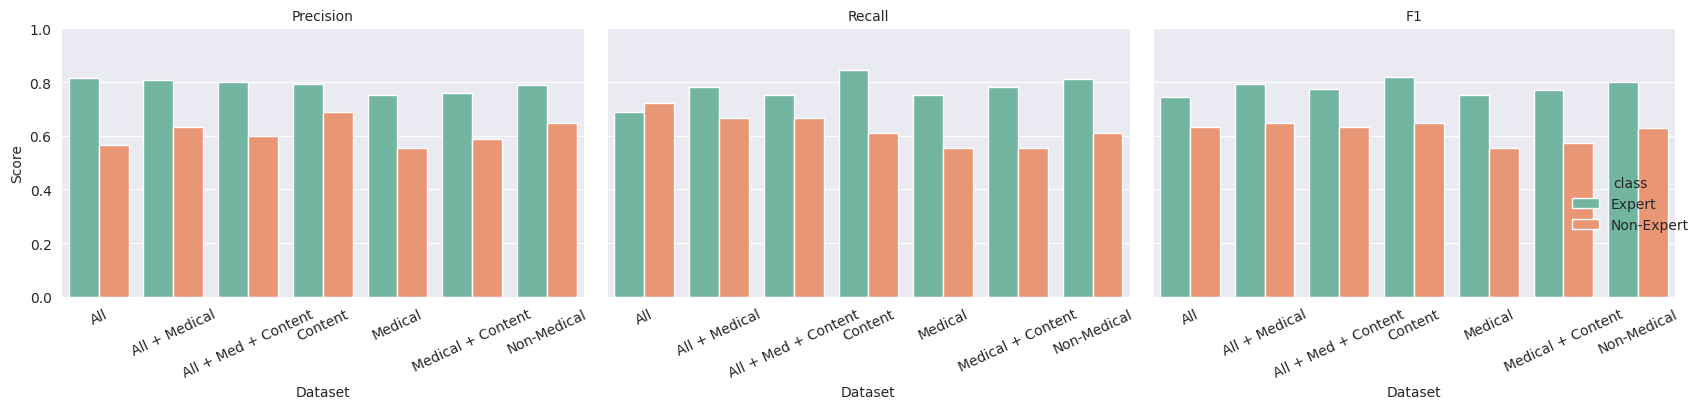

In [31]:
df = pd.read_csv("all_datasets_recomputed_metrics.csv")

best_models = [
    ("All", "LinearSVC", "pca_live"),
    ("All And Medical", "LinearSVC", "pca_live"),
    ("All And Medical And Content", "LogisticRegression", "pca_live"),
    ("Content", "RBFSVC", "pca_live"),
    ("Medical", "LogisticRegression", "select_k_best"),
    ("Medical And Content", "PolySVC", "pca_live"),
    ("Non Medical", "RandomForest", "pca_live"),
]
mask = df.apply(lambda r: (r["dataset"], r["model"], r["method"]) in best_models, axis=1)
best_df = df[mask].copy()

# Tidy to long format
plot_df = pd.melt(
    best_df,
    id_vars=["dataset", "model", "method"],
    value_vars=[
        "expert_precision", "expert_recall", "expert_f1",
        "non_expert_precision", "non_expert_recall", "non_expert_f1"
    ],
    var_name="metric_class", value_name="score"
)

# Parse class and metric correctly
plot_df["class"] = plot_df["metric_class"].apply(
    lambda s: "Non-Expert" if s.startswith("non_expert") else "Expert"
)
def extract_metric(s):
    last = s.split("_")[-1]  # 'precision' | 'recall' | 'f1'
    return "F1" if last.lower() == "f1" else last.capitalize()
plot_df["metric"] = plot_df["metric_class"].apply(extract_metric)

# Optional: prettier dataset labels / order
pretty = {
    "All And Medical And Content": "All + Med + Content",
    "All And Medical": "All + Medical",
    "Non Medical": "Non-Medical",
    "Medical And Content": "Medical + Content",
}
plot_df["dataset_pretty"] = plot_df["dataset"].map(pretty).fillna(plot_df["dataset"])
order = ["All", "All + Medical", "All + Med + Content",
         "Content", "Medical", "Medical + Content", "Non-Medical"]
plot_df["dataset_pretty"] = pd.Categorical(plot_df["dataset_pretty"], categories=order, ordered=True)

# Faceted bar plot
g = sns.catplot(
    data=plot_df, x="dataset_pretty", y="score", hue="class",
    col="metric", kind="bar", palette="Set2",
    height=4.2, aspect=1.25, sharey=True
)
g.set_axis_labels("Dataset", "Score")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.set_ylim(0, 1.0)
    ax.tick_params(axis="x", rotation=25)

plt.tight_layout()
plt.show()
# plt.savefig("class_metrics_best_models.png", dpi=300, bbox_inches="tight")


/tmp/ipykernel_16479/1225403009.py:69: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


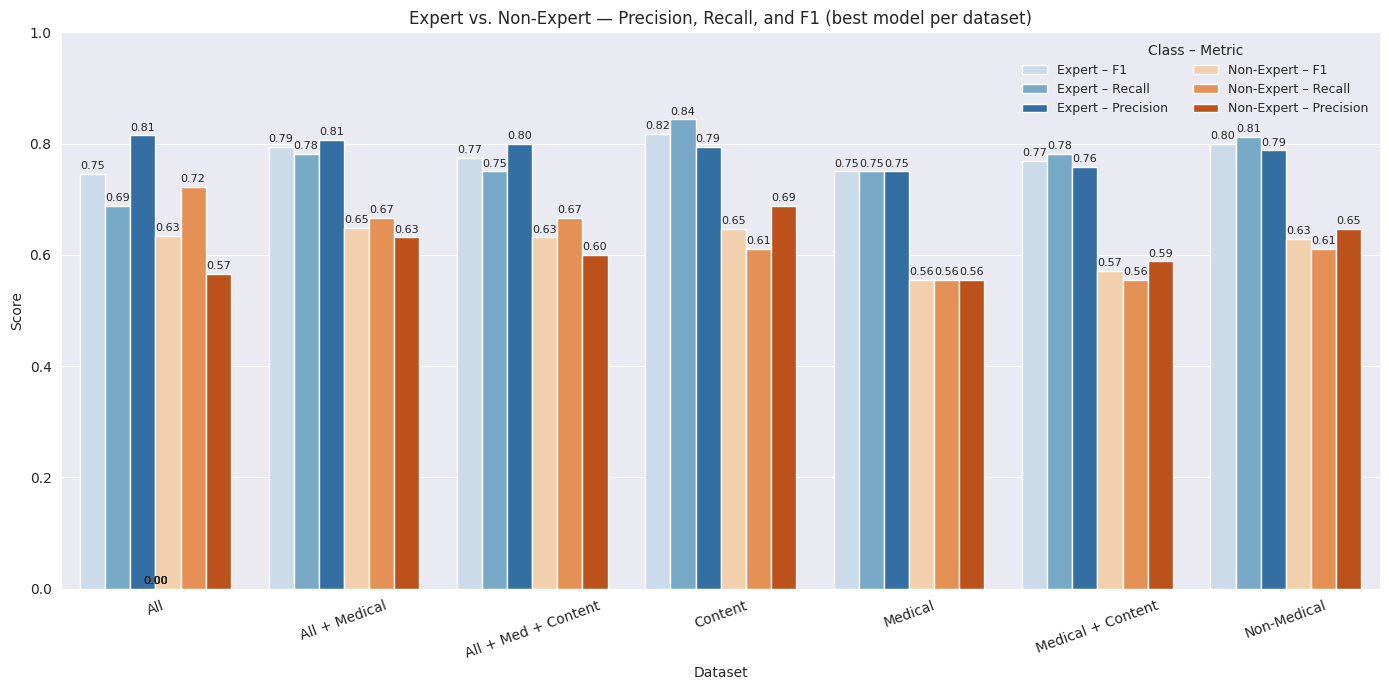

In [40]:
# Load combined metrics
df = pd.read_csv("all_datasets_recomputed_metrics.csv")

# Keep best models only (same as Table 4.1)
best_models = [
    ("All", "LinearSVC", "pca_live"),
    ("All And Medical", "LinearSVC", "pca_live"),
    ("All And Medical And Content", "LogisticRegression", "pca_live"),
    ("Content", "RBFSVC", "pca_live"),
    ("Medical", "LogisticRegression", "select_k_best"),
    ("Medical And Content", "PolySVC", "pca_live"),
    ("Non Medical", "RandomForest", "pca_live"),
]
mask = df.apply(lambda r: (r["dataset"], r["model"], r["method"]) in best_models, axis=1)
best_df = df[mask].copy()

# Tidy to long format
plot_df = pd.melt(
    best_df,
    id_vars=["dataset", "model", "method"],
    value_vars=[
        "expert_precision", "expert_recall", "expert_f1",
        "non_expert_precision", "non_expert_recall", "non_expert_f1"
    ],
    var_name="metric_class", value_name="score"
)

# Parse class + metric
plot_df["class"] = plot_df["metric_class"].apply(
    lambda s: "Non-Expert" if s.startswith("non_expert") else "Expert"
)
def extract_metric(s):
    last = s.split("_")[-1]  # 'precision' | 'recall' | 'f1'
    return "F1" if last.lower() == "f1" else last.capitalize()
plot_df["metric"] = plot_df["metric_class"].apply(extract_metric)

# Pretty dataset labels + fixed order
pretty = {
    "All And Medical And Content": "All + Med + Content",
    "All And Medical": "All + Medical",
    "Non Medical": "Non-Medical",
    "Medical And Content": "Medical + Content",
}
plot_df["dataset_pretty"] = plot_df["dataset"].map(pretty).fillna(plot_df["dataset"])
order = ["All", "All + Medical", "All + Med + Content",
         "Content", "Medical", "Medical + Content", "Non-Medical"]
plot_df["dataset_pretty"] = pd.Categorical(plot_df["dataset_pretty"], categories=order, ordered=True)

# Combine class × metric for a single legend with 6 entries
plot_df["class_metric"] = plot_df["class"] + " – " + plot_df["metric"]

# Reorder the bars as requested: F1, Recall, then Precision
hue_order = [
    "Expert – F1", "Expert – Recall", "Expert – Precision",
    "Non-Expert – F1", "Non-Expert – Recall", "Non-Expert – Precision",
]

# Create a new color palette to group expert and non-expert classes
expert_colors = sns.color_palette("Blues", n_colors=3)
non_expert_colors = sns.color_palette("Oranges", n_colors=3)
new_palette = expert_colors + non_expert_colors

# Plot: one panel, 6 bars per dataset. Increased figure height to accommodate the raised legend.
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=plot_df,
    x="dataset_pretty", y="score",
    hue="class_metric", hue_order=hue_order,
    ci=None, palette=new_palette
)
ax.set_ylim(0, 1.0)
ax.set_xlabel("Dataset")
ax.set_ylabel("Score")
# Recenter the title
ax.set_title("Expert vs. Non-Expert — Precision, Recall, and F1 (best model per dataset)", loc='center')
plt.xticks(rotation=20)

# Optional: value labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width() / 2, height),
                ha="center", va="bottom", fontsize=8, xytext=(0, 2), textcoords="offset points")

# Position the legend inside the plot at the top right, with two columns
ax.legend(
    title="Class – Metric",
    ncol=2,
    fontsize=9,
    title_fontsize=10,
    frameon=False,
    loc='upper right',
)

plt.tight_layout()
plt.show()
# plt.savefig("class_precision_recall_f1_best_models.png", dpi=300, bbox_inches="tight")

In [47]:
MethodType = Literal['rfe', 'select_k_best', 'pca_live', 'pca_precomputed']


def load_and_prep_data(
    method: MethodType,
    raw_file_path: Path,
    pca_file_path: Path,
    n_pca_features_to_use: int = None
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Loads and preprocesses data based on the selected feature reduction method.
    """
    print(f"Loading data for method: '{method}'")
    # For methods that need raw data, preprocess it
    if method in ['rfe', 'pca_live', 'select_k_best']:

        df = pd.read_csv(raw_file_path, sep="\t")


        # 1. Create y with text labels
        y_text = df['is.expert']
        # 2. Encode y to be numeric
        le = LabelEncoder()
        y = pd.Series(le.fit_transform(y_text), name=y_text.name)


        X = df.drop(columns=['Participant_unique', 'is.expert'])

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        X_encoded = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)
        constant_features = [col for col in X_encoded.columns if X_encoded[col].nunique() == 1]
        if constant_features:
            X_final = X_encoded.drop(columns=constant_features)
            print(f"Removed {len(constant_features)} constant features.")
        else:
            X_final = X_encoded

    elif method == 'pca_precomputed':

        df = pd.read_csv(pca_file_path, sep="\t")


        # 1. Create y with text labels
        y_text = df['is.expert']
        # 2. Encode y to be numeric
        le = LabelEncoder()
        y = pd.Series(le.fit_transform(y_text), name=y_text.name)


        X_final = df.drop(columns=['Participant_unique', 'is.expert'])

        if n_pca_features_to_use is not None:

            print(f"Selecting the first {n_pca_features_to_use} principal components.")
            X_final = X_final.iloc[:, :n_pca_features_to_use]

    else:
        raise ValueError(f"Unknown method: {method}")

    print(f"Final shape of feature matrix X: {X_final.shape}")
    return X_final, y

def evaluate_and_extract_features_per_fold(
    X_full: pd.DataFrame,
    y_full: pd.Series,
    method: str,
    classifier: any,
    best_params: dict,
    model_name: str,
    average: Literal['macro', 'weighted'] = 'macro'
) -> Dict[str, Any]:
    """
    Evaluates a pipeline using a manual LOOCV loop to extract both
    feature stability counts and average internal feature rankings/scores.
    """
    print(f"\n--- Running Manual LOOCV for: {model_name} | Method: {method} ---")

    pipeline = build_pipeline(method, classifier)

    existing_step_names = [step[0] for step in pipeline.steps]
    params_to_set = {
        key: value for key, value in best_params.items()
        if key.split('__')[0] in existing_step_names
    }
    pipeline.set_params(**params_to_set)

    loo = LeaveOneOut()
    y_predictions = np.empty(y_full.shape)

    # --- Data structures to store results ---
    per_fold_selections = [] # For stability counts
    all_fold_metrics = []    # For internal ranks/scores

    # --- Manual LOOCV Loop ---
    for i, (train_index, test_index) in enumerate(loo.split(X_full)):
        cloned_pipeline = clone(pipeline)
        X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
        y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]
        cloned_pipeline.fit(X_train, y_train)
        y_predictions[test_index] = cloned_pipeline.predict(X_test)

        # --- Stability Counts & Internal Ranks Extraction ---
        if method == 'rfe':
            feature_selector = cloned_pipeline.named_steps['feature_selection']
            # For stability
            selected_features = X_train.columns[feature_selector.support_].tolist()
            per_fold_selections.extend(selected_features)
            # For internal ranking
            ranks = pd.Series(feature_selector.ranking_, index=X_train.columns)
            all_fold_metrics.append(ranks)

        elif method == 'select_k_best':
            variance_remover = cloned_pipeline.named_steps['variance_threshold']
            feature_selector = cloned_pipeline.named_steps['feature_selection']
            features_after_variance = X_train.columns[variance_remover.get_support()]

            # For stability
            select_k_best_mask = feature_selector.get_support()
            final_selected_features = features_after_variance[select_k_best_mask].tolist()
            per_fold_selections.extend(final_selected_features)

            # For internal scores
            scores = pd.Series(feature_selector.scores_, index=features_after_variance)
            # Reindex to match original columns, filling non-scored features with 0
            all_feature_scores = scores.reindex(X_train.columns, fill_value=0)
            all_fold_metrics.append(all_feature_scores)

    # --- Aggregate and Summarize Results ---
    feature_stability = None
    if per_fold_selections:
        feature_counts = Counter(per_fold_selections)
        feature_stability = dict(feature_counts.most_common())

    feature_internal_rank_stats = None
    if all_fold_metrics:
        metrics_df = pd.concat(all_fold_metrics, axis=1).T
        stats_df = pd.DataFrame({
            'Mean_Rank_or_Score': metrics_df.mean(),
            'Std_Rank_or_Score': metrics_df.std()
        })
        # Sort by what's best for the method
        ascending_sort = True if method == 'rfe' else False # Lower is better for RFE rank
        feature_internal_rank_stats = stats_df.sort_values(by='Mean_Rank_or_Score', ascending=ascending_sort)

    # Calculate overall metrics
    accuracy = accuracy_score(y_full, y_predictions)
    precision = precision_score(y_full, y_predictions, average=average, zero_division=0)
    recall = recall_score(y_full, y_predictions, average=average, zero_division=0)
    f1 = f1_score(y_full, y_predictions, average=average, zero_division=0)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print("-" * 60)

    return {
        "model_name": model_name,
        "method": method,
        "best_params": params_to_set,
        "loocv_accuracy": accuracy,
        f"loocv_precision_{average}": precision,
        f"loocv_recall_{average}": recall,
        f"loocv_f1_{average}": f1,
        "feature_stability_counts": feature_stability,
        "feature_internal_rank_stats": feature_internal_rank_stats
    }

In [52]:
# --- 2. DEFINE THE FILENAMES & PLOTTING OPTION ---
FILENAMES_TO_PROCESS = [
    'ml_features_all_20250709_214248.csv',
    'ml_features_all_and_medical_20250709_213116.csv',
    'ml_features_all_and_medical_and_content_20250709_214000.csv',
    'ml_features_content_20250709_214417.csv',
    'ml_features_medical_20250709_214316.csv',
    'ml_features_medical_and_content_20250709_214355.csv',
    'ml_features_non_medical_20250711_021809.csv'
]

# --- SET TO True TO GENERATE PLOTS, False TO SKIP THEM ---
GENERATE_PLOTS = False # Or False

# --- 3. DEFINE STATIC CONFIGURATIONS ---
PROJECT_ROOT = Path().resolve().parent
DATA_PREP_PATH = PROJECT_ROOT / 'data_prep'
PCA_FILES_PATH = DATA_PREP_PATH / 'pca_files'
VARIMAX_PCA_PATH = DATA_PREP_PATH / 'pca_files_varimax'

RESULTS_PATH = PROJECT_ROOT / 'loocv' / 'results' / 'macro' / 'feature_ranking'
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

METHODS_TO_RUN = ['rfe', 'select_k_best', 'pca_live', 'pca_precomputed']
CLASSIFIERS = {
    'LinearSVC': LinearSVC(class_weight='balanced', dual=False, max_iter=10000, random_state=42),
    'RBFSVC': SVC(kernel='rbf', class_weight='balanced', probability=True, max_iter=10000, random_state=42),
    'PolySVC': SVC(kernel='poly', class_weight='balanced', probability=True, max_iter=10000, random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42)
}
PCA_VARIANCE_THRESHOLD = 0.95
PCA_COMPONENTS_TO_USE = 23
BEST_PARAMS_BY_METHOD = {

    'rfe': {
        'LinearSVC': {'classifier__C': 0.1, 'feature_selection__n_features_to_select': 40},
        'RBFSVC': {'classifier__C': 10, 'classifier__gamma': 'scale', 'feature_selection__n_features_to_select': 80},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 2, 'feature_selection__n_features_to_select': 40},
        'LogisticRegression': {'classifier__C': 1, 'classifier__solver': 'saga', 'feature_selection__n_features_to_select': 40},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'feature_selection__n_features_to_select': 80}
    },
    'select_k_best': {
        'LinearSVC': {'classifier__C': 0.1, 'feature_selection__k': 60},
        'RBFSVC': {'classifier__C': 1, 'classifier__gamma': 'scale', 'feature_selection__k': 40},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 2, 'feature_selection__k': 60},
        'LogisticRegression': {'classifier__C': 1, 'classifier__solver': 'saga', 'feature_selection__k': 60},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'feature_selection__k': 80}
    },
    'pca_live': {
        'LinearSVC': {'classifier__C': 0.1, 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'RBFSVC': {'classifier__C': 10, 'classifier__gamma': 'scale', 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 3, 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'LogisticRegression': {'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'pca__n_components': PCA_VARIANCE_THRESHOLD},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'pca__n_components': PCA_VARIANCE_THRESHOLD}
    },
    'pca_precomputed': {
        'LinearSVC': {'classifier__C': 0.1},
        'RBFSVC': {'classifier__C': 10, 'classifier__gamma': 'scale'},
        'PolySVC': {'classifier__C': 10, 'classifier__degree': 3},
        'LogisticRegression': {'classifier__C': 0.1, 'classifier__solver': 'liblinear'},
        'RandomForest': {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
    }
}


# --- 4. START THE MAIN LOOP TO PROCESS EACH FILE ---
for filename in FILENAMES_TO_PROCESS:
    print(f"\n{'='*30} STARTING ANALYSIS FOR: {filename} {'='*30}")

    # --- SETUP DYNAMIC PATHS FOR THE CURRENT FILE ---
    RAW_DATA_FILE = DATA_PREP_PATH / 'agg_data' / filename
    PCA_DATA_FILENAME = 'pca_rotated_data_' + filename
    PCA_DATA_FILE = VARIMAX_PCA_PATH / PCA_DATA_FILENAME

    if not RAW_DATA_FILE.is_file():
        print(f"WARNING: File not found at {RAW_DATA_FILE}. Skipping this run.")
        continue

    # --- RUN THE ANALYSIS ---
    all_results = []
    for method in METHODS_TO_RUN:
        print(f"\n--- PROCESSING METHOD: {method.upper()} ---")
        X, y = load_and_prep_data(
            method=method, raw_file_path=RAW_DATA_FILE, pca_file_path=PCA_DATA_FILE,
            n_pca_features_to_use=PCA_COMPONENTS_TO_USE if method == 'pca_precomputed' else None
        )
        for model_name, classifier in CLASSIFIERS.items():
            try:
                best_params = BEST_PARAMS_BY_METHOD[method][model_name]
                loocv_result = evaluate_and_extract_features_per_fold(
                    X_full=X, y_full=y, method=method, classifier=classifier,
                    best_params=best_params, model_name=model_name, average='macro'
                )
                all_results.append(loocv_result)
            except KeyError:
                print(f"WARNING: No parameters for {model_name} with method {method}. Skipping.")
            except Exception as e:
                print(f"ERROR: An error occurred for {model_name} with {method}. Skipping. Error: {e}")

    # --- GENERATE AND SAVE REPORT FOR THE CURRENT FILE ---
    print(f"\n{'='*25} GENERATING REPORT FOR: {filename} {'='*25}")
    if not all_results:
        print("No results were generated for this file. Cannot create report.")
        continue

    results_df = pd.DataFrame(all_results)
    results_df['label'] = results_df['model_name'] + ' - ' + results_df['method']
    base_output_name = f"bakeoff_summary_{RAW_DATA_FILE.stem.replace('_ml_features', '')}"

    # --- 1. SAVE THE MAIN SUMMARY TABLE ---
    summary_table_df = results_df.sort_values(by='loocv_accuracy', ascending=False)
    summary_table_filename = RESULTS_PATH / f"{base_output_name}_summary_table.csv"
    summary_table_df.to_csv(summary_table_filename, index=False)
    print(f"Main summary table saved to: {summary_table_filename}")


    # --- 2. SAVE THE DETAILED FEATURE STABILITY REPORTS ---
    print("\n--- Saving Feature Stability/Ranking Reports ---")
    for result in all_results:
        if result.get('feature_stability_counts'):

            base_output_name = f"bakeoff_summary_{RAW_DATA_FILE.stem.replace('_ml_features', '')}"
            model_name = result['model_name']
            method = result['method']

            # Save stability counts
            stability_filename = RESULTS_PATH / f"features_stability_{base_output_name}_{model_name}_{method}.csv"
            stability_dict = result['feature_stability_counts']
            pd.DataFrame(
                list(stability_dict.items()),
                columns=['Feature', 'Stability_Count']
            ).to_csv(stability_filename, index=False)
            print(f"Saved feature stability report for {model_name} ({method}) to: {stability_filename}")

    # --- 3. SAVE THE DETAILED INTERNAL RANKING REPORTS (NEW SECTION) ---
    print("\n--- Saving Internal Ranking/Score Reports ---")
    for result in all_results:
        # Check if the internal rank stats DataFrame exists
        if result.get('feature_internal_rank_stats') is not None:
            base_output_name = f"bakeoff_summary_{RAW_DATA_FILE.stem.replace('_ml_features', '')}"
            model_name = result['model_name']
            method = result['method']

            # Create a descriptive filename
            internal_rank_filename = RESULTS_PATH / f"features_internal_rank_{base_output_name}_{model_name}_{method}.csv"

            # The result is already a DataFrame, so we can save it directly
            rank_df = result['feature_internal_rank_stats']
            rank_df.to_csv(internal_rank_filename, index=True) # index=True to save feature names
            print(f"Saved internal ranking report for {model_name} ({method}) to: {internal_rank_filename}")


    # --- 4. GENERATE AND SAVE PLOTS (OPTIONAL) ---
    if GENERATE_PLOTS:

        print("\n--- Generating and Saving Plots ---")
        sort_options = ['Accuracy (Highest First)', 'Group by Method', 'Group by Model', 'Alphabetical']
        for option in sort_options:
            if option == 'Accuracy (Highest First)':
                sorted_df = results_df.sort_values(by='loocv_accuracy', ascending=False)
            elif option == 'Group by Method':
                sorted_df = results_df.sort_values(by=['method', 'loocv_accuracy'], ascending=[True, False])
            elif option == 'Group by Model':
                sorted_df = results_df.sort_values(by=['model_name', 'loocv_accuracy'], ascending=[True, False])
            else:
                sorted_df = results_df.sort_values(by='label', ascending=True)

            plt.style.use('seaborn-v0_8-whitegrid')
            fig, ax = plt.subplots(figsize=(14, 12))
            sns.barplot(x='loocv_accuracy', y='label', data=sorted_df, palette='viridis', hue='method', ax=ax)
            for p in ax.patches:
                width = p.get_width()
                ax.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.2%}', va='center', fontsize=10)

            ax.set_title(f'Model Bake-Off: {filename}\n(Sorted by: {option})', fontsize=18, pad=20)
            ax.set_xlabel('Robust Mean Accuracy (LOOCV)', fontsize=12)
            ax.set_ylabel('Model - Method', fontsize=12)
            ax.tick_params(axis='y', labelsize=11)
            ax.set_xlim(0, 1.05)
            plt.tight_layout()

            sort_key = option.replace(' ', '_').replace('(', '').replace(')', '')
            # Save plots in the same directory as the summary table
            plot_filename = RESULTS_PATH.parent / f"accuracy_plot_{base_output_name}_{sort_key}.png"

            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f"Plot saved to: {plot_filename}")

print(f"\n{'='*30} ALL FILES PROCESSED {'='*30}")


============================== STARTING ANALYSIS FOR: ml_features_all_20250709_214248.csv ==============================

--- PROCESSING METHOD: RFE ---
Loading data for method: 'rfe'
Removed 83 constant features.
Final shape of feature matrix X: (50, 749)

--- Running Manual LOOCV for: LinearSVC | Method: rfe ---


KeyboardInterrupt: 

In [2]:
def aggregate_feature_rankings():
    """
    Reads all individual feature ranking reports, calculates multiple usage
    metrics, and aggregates them into a single global ranking for each method.
    """
    # --- 1. DEFINE CONSTANTS & PATHS ---
    PROJECT_ROOT = Path().resolve().parent
    RESULTS_PATH = PROJECT_ROOT / 'loocv' / 'results' / 'macro' / 'feature_ranking'
    AGGREGATE_PATH = RESULTS_PATH.parent / 'aggregated_rankings' / 'new'
    AGGREGATE_PATH.mkdir(parents=True, exist_ok=True)

    # Define the number of folds used in the cross-validation
    FOLDS_PER_MODEL = 50

    print(f"Reading individual reports from: {RESULTS_PATH}")
    print(f"Saving aggregated reports to: {AGGREGATE_PATH}\n")

    methods_to_process = ['select_k_best', 'rfe']

    # --- 2. PROCESS EACH METHOD SEPARATELY ---
    for method in methods_to_process:
        print(f"{'='*20} Processing Method: {method.upper()} {'='*20}")

        # --- 3. LOAD ALL RELEVANT FILES ---
        stability_files = list(RESULTS_PATH.glob(f"features_stability_*_{method}.csv"))
        internal_rank_files = list(RESULTS_PATH.glob(f"features_internal_rank_*_{method}.csv"))

        if not stability_files:
            print(f"Warning: No stability report files found for method '{method}'. Skipping.\n")
            continue

        print(f"Found {len(stability_files)} stability reports.")
        if internal_rank_files:
            print(f"Found {len(internal_rank_files)} internal rank reports.")

        all_stability = pd.concat([pd.read_csv(f) for f in stability_files], ignore_index=True)

        # --- 4. CALCULATE AGGREGATE METRICS ---

        # Determine the total number of selection opportunities
        num_models = len(stability_files)
        total_selection_opportunities = num_models * FOLDS_PER_MODEL

        print(f"Aggregating data from {num_models} models with {FOLDS_PER_MODEL} folds each.")
        print(f"Total possible selections per feature: {total_selection_opportunities}\n")

        # METRIC 1: Overall usage across ALL models and folds
        stability_total = all_stability.groupby('Feature')['Stability_Count'].sum().reset_index()
        # Rename for clarity before merging
        stability_total = stability_total.rename(columns={'Stability_Count': 'Total_Stability_Count'})
        stability_total['Overall_Usage_Percentage'] = (stability_total['Total_Stability_Count'] / total_selection_opportunities) * 100

        # METRIC 2: (NEW) Average usage ONLY in models where the feature appeared
        stability_conditional = all_stability.groupby('Feature')['Stability_Count'].mean().reset_index()
        # Rename for clarity and calculate the percentage
        stability_conditional = stability_conditional.rename(columns={'Stability_Count': 'Conditional_Mean_Count'})
        stability_conditional['Conditional_Usage_Percentage'] = (stability_conditional['Conditional_Mean_Count'] / FOLDS_PER_MODEL) * 100

        # Merge the two stability summaries together
        stability_summary = pd.merge(stability_total, stability_conditional, on='Feature', how='outer')

        # --- MERGE AND PROCESS INTERNAL RANKS (if they exist) ---
        if internal_rank_files:
            all_internal = pd.concat([pd.read_csv(f) for f in internal_rank_files], ignore_index=True)
            all_internal = all_internal.rename(columns={'Unnamed: 0': 'Feature'})
            internal_summary = all_internal.groupby('Feature')['Mean_Rank_or_Score'].mean().reset_index()
            # Merge the stability metrics with the internal rank metrics
            global_df = pd.merge(stability_summary, internal_summary, on='Feature', how='outer')
        else:
            global_df = stability_summary

        # Fill NaN values for features that might not appear in all files
        fill_zeros_cols = [
            'Total_Stability_Count', 'Overall_Usage_Percentage',
            'Conditional_Mean_Count', 'Conditional_Usage_Percentage'
        ]
        for col in fill_zeros_cols:
            if col in global_df.columns:
                global_df[col] = global_df[col].fillna(0)


        # --- 5. COMPUTE GLOBAL RANK SCORE ---
        # Rank by overall usage percentage (higher percentage is better)
        global_df['Usage_Rank'] = global_df['Overall_Usage_Percentage'].rank(method='min', ascending=False)

        if internal_rank_files:
            is_rfe = (method == 'rfe')
            fill_value = global_df['Mean_Rank_or_Score'].max() + 1 if is_rfe else global_df['Mean_Rank_or_Score'].min() - 1
            global_df['Mean_Rank_or_Score'] = global_df['Mean_Rank_or_Score'].fillna(fill_value)
            global_df['Internal_Rank'] = global_df['Mean_Rank_or_Score'].rank(method='min', ascending=is_rfe)
            global_df['Global_Score'] = global_df['Usage_Rank'] + global_df['Internal_Rank']
            sort_column = 'Global_Score'
        else:
            sort_column = 'Usage_Rank'

        # Sort the final dataframe
        final_ranking = global_df.sort_values(sort_column, ascending=True).reset_index(drop=True)

        # --- 6. SAVE THE FINAL REPORT ---
        output_file = AGGREGATE_PATH / f"global_feature_ranking_{method}.csv"
        final_ranking.to_csv(output_file, index=False)

        print(f"Successfully created global ranking for '{method}'.")
        print(f"Saved to: {output_file}\n")

    print(f"{'='*20} Aggregation Complete {'='*20}")

aggregate_feature_rankings()

Reading individual reports from: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/feature_ranking
Saving aggregated reports to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/new

==================== Processing Method: SELECT_K_BEST ====================
Found 35 stability reports.
Found 35 internal rank reports.
Aggregating data from 35 models with 50 folds each.
Total possible selections per feature: 1750

Successfully created global ranking for 'select_k_best'.
Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/new/global_feature_ranking_select_k_best.csv

==================== Processing Method: RFE ====================
Found 35 stability reports.
Found 35 internal rank reports.
Aggregating data from 35 models with 50 folds each.
Total possible selections per feature: 1750

Successfully created global ranking for 'rfe'.
Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/ma

In [3]:
def find_models_for_perfect_features():
    """
    Performs a reverse search to identify which specific models/datasets
    used the features that were found to be "perfectly stable" (used in all 50 folds).
    """
    # --- 1. DEFINE PATHS ---
    PROJECT_ROOT = Path().resolve().parent
    RESULTS_PATH = PROJECT_ROOT / 'loocv' / 'results' / 'macro'
    AGGREGATE_PATH = RESULTS_PATH / 'aggregated_rankings' / 'new'
    INDIVIDUAL_REPORTS_PATH = RESULTS_PATH / 'feature_ranking'

    method = 'select_k_best' # 'select_k_best' or 'rfe'

    global_ranking_file = AGGREGATE_PATH / f"global_feature_ranking_{method}.csv"

    if not global_ranking_file.exists():
        print(f"\nError: The global ranking file could not be found.")
        print(f"Searched for: {global_ranking_file}")
        return

    print(f"\nReading global rankings from: {global_ranking_file}")

    # --- 3. IDENTIFY "PERFECT" FEATURES ---
    try:
        global_df = pd.read_csv(global_ranking_file)

        if 'Conditional_Mean_Count' not in global_df.columns:
            print(f"\nError: 'Conditional_Mean_Count' column not found.")
            return

        perfect_features_df = global_df[global_df['Conditional_Mean_Count'] == 50]

        if perfect_features_df.empty:
            print(f"\nNo features found with a Conditional_Mean_Count of 50 for the '{method}' method.")
            return

        perfect_feature_names = perfect_features_df['Feature'].tolist()

        print(f"Found {len(perfect_feature_names)} features with perfect stability (50/50 folds).")
        print("Now searching for them in the individual model reports...\n")

    except Exception as e:
        print(f"An error occurred while reading or processing the file: {e}")
        return

    # --- 4. SEARCH INDIVIDUAL FILES AND COLLECT DATA ---
    appearance_records = []

    individual_files = list(INDIVIDUAL_REPORTS_PATH.glob(f"features_stability_*_{method}.csv"))

    if not individual_files:
        print(f"Warning: No individual stability reports found for method '{method}' in {INDIVIDUAL_REPORTS_PATH}")
        return

    for feature_name in perfect_feature_names:
        for report_file in individual_files:
            try:
                model_features_df = pd.read_csv(report_file)

                if feature_name in model_features_df['Feature'].values:
                    model_name = report_file.name.replace(f"features_stability_", "").replace(f"_{method}.csv", "")
                    # Add a dictionary record for each finding
                    appearance_records.append({'Feature': feature_name, 'Model': model_name})
            except Exception as e:
                print(f"Could not process file {report_file.name}: {e}")

    # --- 5. CREATE DATAFRAME, SAVE TO CSV, AND PRINT REPORT ---
    if not appearance_records:
        print("Search complete, but no appearances were found in the individual files. This is unexpected.")
        return

    # Convert the list of records into a DataFrame
    results_df = pd.DataFrame(appearance_records)
    results_df = results_df.sort_values(by=['Feature', 'Model']).reset_index(drop=True)

    # --- SAVE THE CSV FILE ---
    output_filename = AGGREGATE_PATH / f"perfect_feature_appearances_{method}.csv"
    try:
        results_df.to_csv(output_filename, index=False)
        print(f"\n{'='*20} SUCCESS {'='*20}")
        print(f"Successfully saved the detailed report to:")
        print(f"{output_filename}")
        print(f"{'='*49}\n")
    except Exception as e:
        print(f"\nError: Could not save the CSV file. Reason: {e}")

    # --- PRINT THE CONSOLE SUMMARY ---
    print(f" REVERSE SEARCH SUMMARY FOR METHOD: '{method.upper()}' ")
    print(f"{'='*50}\n")

    # Group by feature to display in the original requested format
    for feature, group in results_df.groupby('Feature'):
        models = group['Model'].tolist()
        print(f"-> Feature: '{feature}'")
        print(f"   -------------------------------------------------")
        print(f"   Appeared in the following {len(models)} dataset(s)/model(s):")
        for model in models:
            print(f"     - {model}")
        print("\n" + "-"*50 + "\n")


find_models_for_perfect_features()



Reading global rankings from: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/new/global_feature_ranking_select_k_best.csv
Found 61 features with perfect stability (50/50 folds).
Now searching for them in the individual model reports...


==================== SUCCESS ====================
Successfully saved the detailed report to:
/mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/new/perfect_feature_appearances_select_k_best.csv

 REVERSE SEARCH SUMMARY FOR METHOD: 'SELECT_K_BEST' 

-> Feature: 'Average_duration_of_Visit_max_clinical_simple'
   -------------------------------------------------
   Appeared in the following 15 dataset(s)/model(s):
     - bakeoff_summary_ml_features_all_20250709_214248_LinearSVC
     - bakeoff_summary_ml_features_all_20250709_214248_LogisticRegression
     - bakeoff_summary_ml_features_all_20250709_214248_PolySVC
     - bakeoff_summary_ml_features_all_20250709_214248_RBFSVC
     - bakeo

In [4]:
def aggregate_feature_rankings_by_dataset():
    """
    Reads all individual feature ranking reports, automatically discovers the
    dataset variants from the filenames, and aggregates feature importance
    metrics separately for each variant and method.
    """
    # --- 1. DEFINE PATHS ---
    PROJECT_ROOT = Path().resolve().parent
    RESULTS_PATH = PROJECT_ROOT / 'loocv' / 'results' / 'macro' / 'feature_ranking'
    AGGREGATE_PATH = RESULTS_PATH.parent / 'aggregated_rankings' / 'by_dataset'
    AGGREGATE_PATH.mkdir(parents=True, exist_ok=True)

    FOLDS_PER_MODEL = 50
    methods_to_process = ['select_k_best', 'rfe']

    print(f"Reading individual reports from: {RESULTS_PATH}")
    print(f"Saving aggregated reports to: {AGGREGATE_PATH}\n")

    # --- 2. DISCOVER DATASET VARIANTS FROM FILENAMES ---
    print("--- Discovering dataset variants from filenames ---")
    all_files = list(RESULTS_PATH.glob("features_stability_*.csv"))

    # Regex to find the dataset variant string (e.g., 'all', 'medical_and_content').
    # It specifically looks for the pattern: ml_features_[variant_name]_[8-digit_date]_[6-digit_time]
    # This is robust enough to handle more complex filenames.
    variant_pattern = re.compile(r'ml_features_([a-zA-Z0-9_+]+)_\d{8}_\d{6}')

    # Dictionaries to group files by variant and method
    variant_files = defaultdict(lambda: defaultdict(list))

    for f in all_files:
        # Normalize '+' to 'and' for consistent variant naming
        normalized_filename = f.name.replace('+', 'and')
        match = variant_pattern.search(normalized_filename)

        if match:
            variant_name = match.group(1)
            # Determine if it's a stability or internal rank file
            if 'stability' in f.name:
                file_type = 'stability'
            elif 'internal_rank' in f.name:
                file_type = 'internal_rank'
            else:
                continue

            # Group the file path by its variant and type
            variant_files[variant_name][file_type].append(f)
        else:
            print(f"Warning: Could not extract dataset variant from filename: {f.name}")

    if not variant_files:
        print("\nError: No dataset variants could be discovered. Please check filenames.")
        return

    print(f"Discovered {len(variant_files)} variants: {list(variant_files.keys())}\n")


    # --- 3. PROCESS EACH DATASET VARIANT SEPARATELY ---
    for variant, files_by_type in variant_files.items():
        print(f"{'='*20} Processing Variant: '{variant.upper()}' {'='*20}")

        for method in methods_to_process:
            print(f"\n--- Method: '{method.upper()}' ---")

            stability_files = [f for f in files_by_type.get('stability', []) if f'_{method}.csv' in f.name or f'_{method}' in f.name]
            internal_rank_files = [f for f in files_by_type.get('internal_rank', []) if f'_{method}.csv' in f.name or f'_{method}' in f.name]


            if not stability_files:
                print(f"No stability reports found for this variant/method combination. Skipping.")
                continue

            print(f"Found {len(stability_files)} stability reports.")
            if internal_rank_files:
                print(f"Found {len(internal_rank_files)} internal rank reports.")

            # --- 4. AGGREGATION LOGIC (Now applied per-variant) ---
            all_stability = pd.concat([pd.read_csv(f) for f in stability_files], ignore_index=True)

            num_models = len(stability_files)
            total_selection_opportunities = num_models * FOLDS_PER_MODEL

            stability_total = all_stability.groupby('Feature')['Stability_Count'].sum().reset_index()
            stability_total = stability_total.rename(columns={'Stability_Count': 'Total_Stability_Count'})
            stability_total['Overall_Usage_Percentage'] = (stability_total['Total_Stability_Count'] / total_selection_opportunities) * 100

            stability_conditional = all_stability.groupby('Feature')['Stability_Count'].mean().reset_index()
            stability_conditional = stability_conditional.rename(columns={'Stability_Count': 'Conditional_Mean_Count'})
            stability_conditional['Conditional_Usage_Percentage'] = (stability_conditional['Conditional_Mean_Count'] / FOLDS_PER_MODEL) * 100

            # CORRECTED THIS LINE: Added '=' to the 'on' parameter
            stability_summary = pd.merge(stability_total, stability_conditional, on='Feature', how='outer')

            if internal_rank_files:
                all_internal = pd.concat([pd.read_csv(f) for f in internal_rank_files], ignore_index=True)
                all_internal = all_internal.rename(columns={'Unnamed: 0': 'Feature'})
                internal_summary = all_internal.groupby('Feature')['Mean_Rank_or_Score'].mean().reset_index()
                global_df = pd.merge(stability_summary, internal_summary, on='Feature', how='outer')
            else:
                global_df = stability_summary

            # Fill NaNs and compute ranks
            fill_cols = ['Total_Stability_Count', 'Overall_Usage_Percentage', 'Conditional_Mean_Count', 'Conditional_Usage_Percentage']
            global_df[fill_cols] = global_df[fill_cols].fillna(0)

            global_df['Usage_Rank'] = global_df['Overall_Usage_Percentage'].rank(method='min', ascending=False)
            sort_column = 'Usage_Rank'

            if internal_rank_files:
                is_rfe = (method == 'rfe')
                fill_val = global_df['Mean_Rank_or_Score'].max() + 1 if is_rfe else global_df['Mean_Rank_or_Score'].min() - 1
                global_df['Mean_Rank_or_Score'] = global_df['Mean_Rank_or_Score'].fillna(fill_val)
                global_df['Internal_Rank'] = global_df['Mean_Rank_or_Score'].rank(method='min', ascending=is_rfe)
                global_df['Global_Score'] = global_df['Usage_Rank'] + global_df['Internal_Rank']
                sort_column = 'Global_Score'

            final_ranking = global_df.sort_values(sort_column, ascending=True).reset_index(drop=True)

            # --- 5. SAVE THE VARIANT-SPECIFIC REPORT ---
            output_file = AGGREGATE_PATH / f"global_ranking_{variant}_{method}.csv"
            final_ranking.to_csv(output_file, index=False)

            print(f"Successfully created ranking for variant '{variant}'. Saved to: {output_file}")

    print(f"\n{'='*20} Aggregation Complete {'='*20}")

aggregate_feature_rankings_by_dataset()

Reading individual reports from: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/feature_ranking
Saving aggregated reports to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_dataset

--- Discovering dataset variants from filenames ---
Discovered 7 variants: ['all', 'all_and_medical', 'all_and_medical_and_content', 'content', 'medical', 'medical_and_content', 'non_medical']

==================== Processing Variant: 'ALL' ====================

--- Method: 'SELECT_K_BEST' ---
Found 5 stability reports.
Successfully created ranking for variant 'all'. Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_dataset/global_ranking_all_select_k_best.csv

--- Method: 'RFE' ---
Found 5 stability reports.
Successfully created ranking for variant 'all'. Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_dataset/global_ranking_all_rfe.csv
===================

In [5]:
def unconstruct_and_analyze_features(df, output_path_base, variant, method):
    """
    Deconstructs feature names into their base components, statistics, types,
    and versions, then counts the occurrences of each component for each base feature.
    """
    print(f"--- Starting Unconstructed Feature Analysis for '{variant}' ---")
    feature_list = df['Feature'].tolist()
    analysis_data = defaultdict(lambda: defaultdict(int))

    # Define known components for parsing
    stats = ['mean', 'std', 'min', 'max']
    types = ['medical', 'clinical']
    versions = ['original', 'simple', 'simplified']
    subsets = ['medical', 'non_medical', 'content'] # Suffixes from targeted subsets

    for feature in feature_list:
        base_feature = feature
        components_found = {}

        # 1. Check for special subset suffixes first as they are unique
        is_subset_feature = False
        for subset in subsets:
            suffix = f'_{subset}'
            if feature.endswith(suffix):
                components_found['subset'] = subset
                base_feature = feature[:-len(suffix)]
                is_subset_feature = True
                break

        # 2. Extract the statistic, which is usually right before other components
        temp_base = base_feature
        for stat in stats:
            suffix = f'_{stat}'
            if temp_base.endswith(suffix):
                components_found['stat'] = stat
                temp_base = temp_base[:-len(suffix)]
                break

        # 3. If it wasn't a special subset, check for type and version from the remaining parts
        if not is_subset_feature:
            remaining_parts = temp_base.split('_')
            # Check for version (e.g., 'simple')
            if remaining_parts and remaining_parts[-1] in versions:
                components_found['version'] = remaining_parts[-1]
                remaining_parts.pop()
            # Check for type (e.g., 'medical')
            if remaining_parts and remaining_parts[-1] in types:
                components_found['type'] = remaining_parts[-1]
                remaining_parts.pop()
            final_base = '_'.join(remaining_parts)
        else:
            # If it was a subset feature, what's left is the base feature
            final_base = temp_base

        if not final_base:
            continue

        # 4. Update counts for the discovered base feature and its components
        analysis_data[final_base]['Total_Appearances'] += 1
        for comp_type, comp_value in components_found.items():
            analysis_data[final_base][f"Component_{comp_type}_{comp_value}"] += 1

    if not analysis_data:
        print("No features to analyze for unconstruction.")
        return

    # 5. Convert to a DataFrame and save
    analysis_df = pd.DataFrame.from_dict(analysis_data, orient='index')
    analysis_df = analysis_df.fillna(0).astype(int)
    analysis_df.sort_values(by='Total_Appearances', ascending=False, inplace=True)
    analysis_df = analysis_df.reset_index().rename(columns={'index': 'Base_Feature'})

    output_file = output_path_base / f"unconstructed_analysis_{variant}_{method}.csv"
    analysis_df.to_csv(output_file, index=False)
    print(f"Successfully created unconstructed feature analysis. Saved to: {output_file}")


def aggregate_feature_rankings_by_dataset():
    """
    Reads all individual feature ranking reports, automatically discovers the
    dataset variants from the filenames, and aggregates feature importance
    metrics separately for each variant and method.
    """
    # --- 1. DEFINE PATHS ---
    PROJECT_ROOT = Path().resolve().parent
    RESULTS_PATH = PROJECT_ROOT / 'loocv' / 'results' / 'macro' / 'feature_ranking'
    AGGREGATE_PATH = RESULTS_PATH.parent / 'aggregated_rankings' / 'by_dataset_new'
    AGGREGATE_PATH.mkdir(parents=True, exist_ok=True)

    FOLDS_PER_MODEL = 50
    methods_to_process = ['select_k_best', 'rfe']

    print(f"Reading individual reports from: {RESULTS_PATH}")
    print(f"Saving aggregated reports to: {AGGREGATE_PATH}\n")

    # --- 2. DISCOVER DATASET VARIANTS FROM FILENAMES ---
    print("--- Discovering dataset variants from filenames ---")
    all_files = list(RESULTS_PATH.glob("features_stability_*.csv")) + list(RESULTS_PATH.glob("features_internal_rank_*.csv"))

    variant_pattern = re.compile(r'ml_features_([a-zA-Z0-9_+]+)_\d{8}_\d{6}')
    variant_files = defaultdict(lambda: defaultdict(list))

    for f in all_files:
        normalized_filename = f.name.replace('+', 'and')
        match = variant_pattern.search(normalized_filename)
        if match:
            variant_name = match.group(1)
            file_type = 'stability' if 'stability' in f.name else 'internal_rank'
            variant_files[variant_name][file_type].append(f)
        else:
            print(f"Warning: Could not extract dataset variant from filename: {f.name}")

    if not variant_files:
        print("\nError: No dataset variants could be discovered. Please check filenames.")
        return

    print(f"Discovered {len(variant_files)} variants: {list(variant_files.keys())}\n")

    # --- 3. PROCESS EACH DATASET VARIANT SEPARATELY ---
    for variant, files_by_type in variant_files.items():
        print(f"{'='*20} Processing Variant: '{variant.upper()}' {'='*20}")

        for method in methods_to_process:
            print(f"\n--- Method: '{method.upper()}' ---")

            stability_files = [f for f in files_by_type.get('stability', []) if f'_{method}.csv' in f.name or f'_{method}' in f.name]
            internal_rank_files = [f for f in files_by_type.get('internal_rank', []) if f'_{method}.csv' in f.name or f'_{method}' in f.name]

            if not stability_files:
                print(f"No stability reports found for this variant/method combination. Skipping.")
                continue

            print(f"Found {len(stability_files)} stability reports.")
            if internal_rank_files:
                print(f"Found {len(internal_rank_files)} internal rank reports.")

            # --- 4. AGGREGATION LOGIC (Now applied per-variant) ---
            all_stability = pd.concat([pd.read_csv(f) for f in stability_files], ignore_index=True)

            num_models = len(stability_files)
            total_selection_opportunities = num_models * FOLDS_PER_MODEL

            stability_total = all_stability.groupby('Feature')['Stability_Count'].sum().reset_index()
            stability_total = stability_total.rename(columns={'Stability_Count': 'Total_Stability_Count'})
            stability_total['Overall_Usage_Percentage'] = (stability_total['Total_Stability_Count'] / total_selection_opportunities) * 100

            stability_conditional = all_stability.groupby('Feature')['Stability_Count'].mean().reset_index()
            stability_conditional = stability_conditional.rename(columns={'Stability_Count': 'Conditional_Mean_Count'})
            stability_conditional['Conditional_Usage_Percentage'] = (stability_conditional['Conditional_Mean_Count'] / FOLDS_PER_MODEL) * 100

            stability_summary = pd.merge(stability_total, stability_conditional, on='Feature', how='outer')

            if internal_rank_files:
                all_internal = pd.concat([pd.read_csv(f) for f in internal_rank_files], ignore_index=True)
                all_internal = all_internal.rename(columns={'Unnamed: 0': 'Feature'})
                internal_summary = all_internal.groupby('Feature')['Mean_Rank_or_Score'].mean().reset_index()
                global_df = pd.merge(stability_summary, internal_summary, on='Feature', how='outer')
            else:
                global_df = stability_summary

            fill_cols = ['Total_Stability_Count', 'Overall_Usage_Percentage', 'Conditional_Mean_Count', 'Conditional_Usage_Percentage']
            global_df[fill_cols] = global_df[fill_cols].fillna(0)

            global_df['Usage_Rank'] = global_df['Overall_Usage_Percentage'].rank(method='min', ascending=False)
            sort_column = 'Usage_Rank'

            if internal_rank_files:
                is_rfe = (method == 'rfe')
                fill_val = global_df['Mean_Rank_or_Score'].max() + 1 if is_rfe else global_df['Mean_Rank_or_Score'].min() - 1
                global_df['Mean_Rank_or_Score'] = global_df['Mean_Rank_or_Score'].fillna(fill_val)
                global_df['Internal_Rank'] = global_df['Mean_Rank_or_Score'].rank(method='min', ascending=is_rfe)
                global_df['Global_Score'] = global_df['Usage_Rank'] + global_df['Internal_Rank']
                sort_column = 'Global_Score'

            final_ranking = global_df.sort_values(sort_column, ascending=True).reset_index(drop=True)

            # --- 5. SAVE THE VARIANT-SPECIFIC REPORT ---
            output_file = AGGREGATE_PATH / f"global_ranking_{variant}_{method}.csv"
            final_ranking.to_csv(output_file, index=False)
            print(f"Successfully created ranking for variant '{variant}'. Saved to: {output_file}")

            # --- 6. (NEW) RUN UNCONSTRUCTED FEATURE ANALYSIS ---
            unconstruct_and_analyze_features(final_ranking, AGGREGATE_PATH, variant, method)

    print(f"\n{'='*20} Aggregation Complete {'='*20}")

aggregate_feature_rankings_by_dataset()



Reading individual reports from: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/feature_ranking
Saving aggregated reports to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_dataset_new

--- Discovering dataset variants from filenames ---
Discovered 7 variants: ['all', 'all_and_medical', 'all_and_medical_and_content', 'content', 'medical', 'medical_and_content', 'non_medical']

==================== Processing Variant: 'ALL' ====================

--- Method: 'SELECT_K_BEST' ---
Found 5 stability reports.
Found 5 internal rank reports.
Successfully created ranking for variant 'all'. Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_dataset_new/global_ranking_all_select_k_best.csv
--- Starting Unconstructed Feature Analysis for 'all' ---
Successfully created unconstructed feature analysis. Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_da

In [7]:
def unconstruct_and_analyze_features(df, output_path_base, variant, method):
    """
    Deconstructs feature names and analyzes the components based on their ranks
    in the provided dataframe, creating a multi-sheet Excel report.
    """
    print(f"--- Starting Unconstructed Feature Analysis for '{variant}' ---")

    # Define known components for parsing
    stats = ['mean', 'std', 'min', 'max']
    types = ['medical', 'clinical']
    versions = ['original', 'simple', 'simplified']
    subsets = ['medical', 'non_medical', 'content']

    # Dictionaries to hold rank-aware stats for each component type
    component_stats = {
        'Base_Feature': defaultdict(lambda: {'count': 0, 'ranks': []}),
        'Statistic': defaultdict(lambda: {'count': 0, 'ranks': []}),
        'Text_Type': defaultdict(lambda: {'count': 0, 'ranks': []}),
        'Text_Version': defaultdict(lambda: {'count': 0, 'ranks': []}),
        'Subset': defaultdict(lambda: {'count': 0, 'ranks': []})
    }

    # 1. Iterate over the ranked dataframe to parse features and collect ranks
    for rank, row in df.iterrows():
        feature = row['Feature']
        current_rank = rank + 1  # Rank is index + 1 as the df is sorted
        base_feature = feature
        components_found = {}

        # Parsing logic (similar to before but adapted for new structure)
        is_subset_feature = False
        for subset in subsets:
            suffix = f'_{subset}'
            if feature.endswith(suffix):
                components_found['Subset'] = subset
                base_feature = feature[:-len(suffix)]
                is_subset_feature = True
                break

        temp_base = base_feature
        for stat in stats:
            suffix = f'_{stat}'
            if temp_base.endswith(suffix):
                components_found['Statistic'] = stat
                temp_base = temp_base[:-len(suffix)]
                break

        if not is_subset_feature:
            remaining_parts = temp_base.split('_')
            if remaining_parts and remaining_parts[-1] in versions:
                components_found['Text_Version'] = remaining_parts.pop()
            if remaining_parts and remaining_parts[-1] in types:
                components_found['Text_Type'] = remaining_parts.pop()
            final_base = '_'.join(remaining_parts)
        else:
            final_base = temp_base

        if not final_base:
            continue

        # Update stats for the base feature
        base_stats = component_stats['Base_Feature'][final_base]
        base_stats['count'] += 1
        base_stats['ranks'].append(current_rank)

        # Update stats for each other found component
        for comp_type, comp_value in components_found.items():
            stats_dict = component_stats[comp_type][comp_value]
            stats_dict['count'] += 1
            stats_dict['ranks'].append(current_rank)

    # 2. Process the collected stats to create summary DataFrames
    summary_dfs = {}
    for component_name, stats_dict in component_stats.items():
        if not stats_dict:
            continue

        records = []
        for item, data in stats_dict.items():
            ranks = data['ranks']
            records.append({
                component_name: item,
                'count': data['count'],
                'avg_rank': sum(ranks) / len(ranks) if ranks else 0,
                'std_dev_rank': pd.Series(ranks).std(),
                'top_10_count': sum(1 for r in ranks if r <= 10),
                'top_50_count': sum(1 for r in ranks if r <= 50)
            })

        summary_df = pd.DataFrame(records).sort_values(by='avg_rank', ascending=True).reset_index(drop=True)
        summary_dfs[component_name] = summary_df

    # 3. Save all summary DataFrames to a single multi-sheet Excel file
    if not summary_dfs:
        print("No features to analyze for unconstruction.")
        return

    output_file = output_path_base / f"unconstructed_analysis_{variant}_{method}.xlsx"
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        for sheet_name, df_to_write in summary_dfs.items():
            df_to_write.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Successfully created unconstructed feature analysis. Saved to: {output_file}")


def aggregate_feature_rankings_by_dataset():
    """
    Reads all individual feature ranking reports, automatically discovers the
    dataset variants from the filenames, and aggregates feature importance
    metrics separately for each variant and method.
    """
    # --- 1. DEFINE PATHS ---
    PROJECT_ROOT = Path().resolve().parent
    RESULTS_PATH = PROJECT_ROOT / 'loocv' / 'results' / 'macro' / 'feature_ranking'
    AGGREGATE_PATH = RESULTS_PATH.parent / 'aggregated_rankings' / 'by_dataset_multi'
    AGGREGATE_PATH.mkdir(parents=True, exist_ok=True)

    FOLDS_PER_MODEL = 50
    methods_to_process = ['select_k_best', 'rfe']

    print(f"Reading individual reports from: {RESULTS_PATH}")
    print(f"Saving aggregated reports to: {AGGREGATE_PATH}\n")

    # --- 2. DISCOVER DATASET VARIANTS FROM FILENAMES ---
    print("--- Discovering dataset variants from filenames ---")
    all_files = list(RESULTS_PATH.glob("features_stability_*.csv")) + list(RESULTS_PATH.glob("features_internal_rank_*.csv"))

    variant_pattern = re.compile(r'ml_features_([a-zA-Z0-9_+]+)_\d{8}_\d{6}')
    variant_files = defaultdict(lambda: defaultdict(list))

    for f in all_files:
        normalized_filename = f.name.replace('+', 'and')
        match = variant_pattern.search(normalized_filename)
        if match:
            variant_name = match.group(1)
            file_type = 'stability' if 'stability' in f.name else 'internal_rank'
            variant_files[variant_name][file_type].append(f)
        else:
            print(f"Warning: Could not extract dataset variant from filename: {f.name}")

    if not variant_files:
        print("\nError: No dataset variants could be discovered. Please check filenames.")
        return

    print(f"Discovered {len(variant_files)} variants: {list(variant_files.keys())}\n")

    # --- 3. PROCESS EACH DATASET VARIANT SEPARATELY ---
    for variant, files_by_type in variant_files.items():
        print(f"{'='*20} Processing Variant: '{variant.upper()}' {'='*20}")

        for method in methods_to_process:
            print(f"\n--- Method: '{method.upper()}' ---")

            stability_files = [f for f in files_by_type.get('stability', []) if f'_{method}.csv' in f.name or f'_{method}' in f.name]
            internal_rank_files = [f for f in files_by_type.get('internal_rank', []) if f'_{method}.csv' in f.name or f'_{method}' in f.name]

            if not stability_files:
                print(f"No stability reports found for this variant/method combination. Skipping.")
                continue

            print(f"Found {len(stability_files)} stability reports.")
            if internal_rank_files:
                print(f"Found {len(internal_rank_files)} internal rank reports.")

            # --- 4. AGGREGATION LOGIC (Now applied per-variant) ---
            all_stability = pd.concat([pd.read_csv(f) for f in stability_files], ignore_index=True)

            num_models = len(stability_files)
            total_selection_opportunities = num_models * FOLDS_PER_MODEL

            stability_total = all_stability.groupby('Feature')['Stability_Count'].sum().reset_index()
            stability_total = stability_total.rename(columns={'Stability_Count': 'Total_Stability_Count'})
            stability_total['Overall_Usage_Percentage'] = (stability_total['Total_Stability_Count'] / total_selection_opportunities) * 100

            stability_conditional = all_stability.groupby('Feature')['Stability_Count'].mean().reset_index()
            stability_conditional = stability_conditional.rename(columns={'Stability_Count': 'Conditional_Mean_Count'})
            stability_conditional['Conditional_Usage_Percentage'] = (stability_conditional['Conditional_Mean_Count'] / FOLDS_PER_MODEL) * 100

            stability_summary = pd.merge(stability_total, stability_conditional, on='Feature', how='outer')

            if internal_rank_files:
                all_internal = pd.concat([pd.read_csv(f) for f in internal_rank_files], ignore_index=True)
                all_internal = all_internal.rename(columns={'Unnamed: 0': 'Feature'})
                internal_summary = all_internal.groupby('Feature')['Mean_Rank_or_Score'].mean().reset_index()
                global_df = pd.merge(stability_summary, internal_summary, on='Feature', how='outer')
            else:
                global_df = stability_summary

            fill_cols = ['Total_Stability_Count', 'Overall_Usage_Percentage', 'Conditional_Mean_Count', 'Conditional_Usage_Percentage']
            global_df[fill_cols] = global_df[fill_cols].fillna(0)

            global_df['Usage_Rank'] = global_df['Overall_Usage_Percentage'].rank(method='min', ascending=False)
            sort_column = 'Usage_Rank'

            if internal_rank_files:
                is_rfe = (method == 'rfe')
                fill_val = global_df['Mean_Rank_or_Score'].max() + 1 if is_rfe else global_df['Mean_Rank_or_Score'].min() - 1
                global_df['Mean_Rank_or_Score'] = global_df['Mean_Rank_or_Score'].fillna(fill_val)
                global_df['Internal_Rank'] = global_df['Mean_Rank_or_Score'].rank(method='min', ascending=is_rfe)
                global_df['Global_Score'] = global_df['Usage_Rank'] + global_df['Internal_Rank']
                sort_column = 'Global_Score'

            final_ranking = global_df.sort_values(sort_column, ascending=True).reset_index(drop=True)

            # --- 5. SAVE THE VARIANT-SPECIFIC REPORT ---
            output_file = AGGREGATE_PATH / f"global_ranking_{variant}_{method}.csv"
            final_ranking.to_csv(output_file, index=False)
            print(f"Successfully created ranking for variant '{variant}'. Saved to: {output_file}")

            # --- 6. (NEW) RUN UNCONSTRUCTED FEATURE ANALYSIS ---
            unconstruct_and_analyze_features(final_ranking, AGGREGATE_PATH, variant, method)

    print(f"\n{'='*20} Aggregation Complete {'='*20}")


aggregate_feature_rankings_by_dataset()



Reading individual reports from: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/feature_ranking
Saving aggregated reports to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_dataset_multi

--- Discovering dataset variants from filenames ---
Discovered 7 variants: ['all', 'all_and_medical', 'all_and_medical_and_content', 'content', 'medical', 'medical_and_content', 'non_medical']

==================== Processing Variant: 'ALL' ====================

--- Method: 'SELECT_K_BEST' ---
Found 5 stability reports.
Found 5 internal rank reports.
Successfully created ranking for variant 'all'. Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/by_dataset_multi/global_ranking_all_select_k_best.csv
--- Starting Unconstructed Feature Analysis for 'all' ---
Successfully created unconstructed feature analysis. Saved to: /mnt/c/Users/Consti/PycharmProjects/BasicML/loocv/results/macro/aggregated_rankings/b